<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html Project1.do.txt  -->
<!-- dom:TITLE: Project 1 on Machine Learning, deadline October 9 (midnight), 2023 -->

# Project 1 on Machine Learning, deadline October 9 (midnight), 2023
**[Data Analysis and Machine Learning FYS-STK3155/FYS4155](http://www.uio.no/studier/emner/matnat/fys/FYS3155/index-eng.html)**, University of Oslo, Norway

Date: **September 3**

## Regression analysis and resampling methods

The main aim of this project is to study in more detail various
regression methods, including the Ordinary Least Squares (OLS) method.
In addition to the scientific part, in this course we want also to
give you an experience in writing scientific reports.  The format for
the delivery of your answers is namely that of a scientific report. At
for example
<https://github.com/CompPhysics/MachineLearning/blob/master/doc/Projects/EvaluationGrading/EvaluationForm.md>
we detail how to write a report. Furthermore, at
<https://github.com/CompPhysics/MachineLearning/blob/master/doc/Projects/ReportExample/>
you can find examples of previous reports. How to write reports will
also be discussed during the various lab sessions.

**A small recommendation when developing the codes here**. Instead of
jumping on to the two-dimensional function described below, we
recommend to do the code development and testing with a simpler
one-dimensional function, similar to those discussed in the exercises
of weeks 35 and 36. A simple test, as discussed during the lectures the first
two weeks is to set the design matrix equal to the identity
matrix. Then your model should give a mean square error which is exactly equal to zero.
When you are sure that your codes function well, you can then replace
the one-dimensional test function with the two-dimensional **Franke** function
discussed here.

The Franke function serves as a stepping stone towards the analysis of
real topographic data. The latter is the last part of this project.

### Description of two-dimensional function

We will first study how to fit polynomials to a specific
two-dimensional function called [Franke's
function](http://www.dtic.mil/dtic/tr/fulltext/u2/a081688.pdf).  This
is a function which has been widely used when testing various
interpolation and fitting algorithms. Furthermore, after having
established the model and the method, we will employ resamling
techniques such as cross-validation and/or bootstrap in order to perform a
proper assessment of our models. We will also study in detail the
so-called Bias-Variance trade off.

The Franke function, which is a weighted sum of four exponentials  reads as follows

$$
\begin{align*}
f(x,y) &= \frac{3}{4}\exp{\left(-\frac{(9x-2)^2}{4} - \frac{(9y-2)^2}{4}\right)}+\frac{3}{4}\exp{\left(-\frac{(9x+1)^2}{49}- \frac{(9y+1)}{10}\right)} \\
&+\frac{1}{2}\exp{\left(-\frac{(9x-7)^2}{4} - \frac{(9y-3)^2}{4}\right)} -\frac{1}{5}\exp{\left(-(9x-4)^2 - (9y-7)^2\right) }.
\end{align*}
$$

The function will be defined for $x,y\in [0,1]$.  In a sense, our data are thus scaled to a particular domain for the input values.

Our first step will
be to perform an OLS regression analysis of this function, trying out
a polynomial fit with an $x$ and $y$ dependence of the form $[x, y,
x^2, y^2, xy, \dots]$. We will also include bootstrap first as a
resampling technique.  After that we will include the cross-validation
technique.

We can
use a uniform distribution to set up the arrays of values for $x$ and
$y$, or as in the example below just a set of fixed values for $x$ and
$y$ with a given step size.  We will fit a function (for example a
polynomial) of $x$ and $y$.  Thereafter we will repeat much of the
same procedure using the Ridge and Lasso regression methods,
introducing thus a dependence on the bias (penalty) $\lambda$.

Finally we are going to use (real) digital terrain data and try to
reproduce these data using the same methods. We will also try to go
beyond the second-order polynomials metioned above and explore 
which polynomial fits the data best.

The Python code for the Franke function is included here (it performs also a three-dimensional plot of it)

In [78]:
#All packages need for this assignment:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

C:\Users\camil\AppData\Local\Temp\ipykernel_17044\3178321233.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


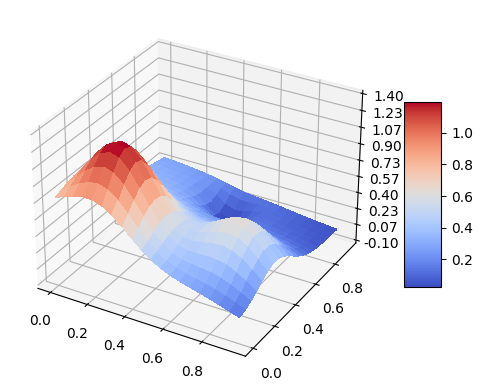

In [118]:
np.random.seed(0)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Part a) : Ordinary Least Square (OLS) on the Franke function

We will generate our own dataset for a function
$\mathrm{FrankeFunction}(x,y)$ with $x,y \in [0,1]$. The function
$f(x,y)$ is the Franke function. You should explore also the addition
of an added stochastic noise to this function using the normal
distribution $N(0,1)$.

*Write your own code* (using either a matrix inversion or a singular
value decomposition from e.g., **numpy** ) and perform a standard **ordinary least square regression**
analysis using polynomials in $x$ and $y$ up to fifth order.

Evaluate the mean Squared error (MSE)

$$
MSE(\boldsymbol{y},\tilde{\boldsymbol{y}}) = \frac{1}{n}
\sum_{i=0}^{n-1}(y_i-\tilde{y}_i)^2,
$$

In [80]:
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

and the $R^2$ score function.  If $\tilde{\boldsymbol{y}}_i$ is the predicted
value of the $i-th$ sample and $y_i$ is the corresponding true value,
then the score $R^2$ is defined as

$$
R^2(\boldsymbol{y}, \tilde{\boldsymbol{y}}) = 1 - \frac{\sum_{i=0}^{n - 1} (y_i - \tilde{y}_i)^2}{\sum_{i=0}^{n - 1} (y_i - \bar{y})^2},
$$

where we have defined the mean value  of $\boldsymbol{y}$ as

$$
\bar{y} =  \frac{1}{n} \sum_{i=0}^{n - 1} y_i.
$$

In [81]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

Plot the resulting scores (MSE and $R^2$) as functions of the polynomial degree (here up to polymial degree five).
Plot also the parameters $\beta$ as you increase the order of the polynomial. Comment your results.

Your code has to include a scaling/centering of the data (for example by
subtracting the mean value), and
a split of the data in training and test data. For this exercise you can
either write your own code or use for example the function for
splitting training data provided by the library **Scikit-Learn** (make
sure you have installed it).  This function is called
$train\_test\_split$.  **You should present a critical discussion of why and how you have scaled or not scaled the data**.

It is normal in essentially all Machine Learning studies to split the
data in a training set and a test set (eventually  also an additional
validation set).  There
is no explicit recipe for how much data should be included as training
data and say test data.  An accepted rule of thumb is to use
approximately $2/3$ to $4/5$ of the data as training data.

You can easily reuse the solutions to your exercises from week 35 and week 36.
See also the lecture slides from week 35 and week 36.

In [119]:
#Adding noise to the Franke function:
z += np.random.normal(0, 1)
z = np.ravel(z)

In [83]:
#Plotting MSE or R^2 score
def plot_stat(stat_test, stat_train, stat_text, polydegree):
     plt.plot(polydegree, stat_test, 'r--', label='Test')
     plt.plot(polydegree, stat_train, label='Train')
     if stat_text == "MSE":
          plt.title("Mean Squared Error as a function of polynomial degree")
          plt.ylabel(stat_text)
     elif stat_text == "R2_Score":
          plt.title("R2 Score as a function of polynomial degree")
          plt.ylabel(stat_text)
     plt.xlabel("degree")

     plt.legend()
     plt.show()

In [84]:
#Plotting the betas in a 3D-plot
def plot_beta(X, z, beta, degree):
     fig = plt.figure()
     ax = fig.gca(projection='3d')
     #x, y = np.meshgrid(x,y)
     # Plot the surface.
     # Plot the surface.
     surf_1 = ax.scatter3D(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
     z_predict = np.reshape(X@beta, x.shape)
     surf_2 = ax.plot_surface(x, y, z_predict, cmap=cm.coolwarm, linewidth=0, antialiased=False)

     # Add a color bar which maps values to colors.
     fig.colorbar(surf_2)
     plt.title(f"Betas for polynomial of degree: {degree}")
     # Make legend, set axes limits and labels
     ax.set_xlim(0, 1)
     ax.set_ylim(0, 1)

     ax.set_xlabel('x')
     ax.set_ylabel('y')
     ax.set_zlabel('z')
     
     plt.show()

In [85]:
def plot_terrain(X, beta, degree):
    # Show the terrain
    plt.figure()
    plt.title(f"Fitted terrain from OLS of polynomial degree {degree}")
    z = np.reshape(X@beta, (1800, 1800))
    plt.imshow(z, cmap='gray')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [86]:
# SVD inversion
def SVDinv(A):
    U, s, VT = np.linalg.svd(A)
    # reciprocals of singular values of s
    d = 1.0 / s
    # create m x n D matrix
    D = np.zeros(A.shape)
    # populate D with n x n diagonal matrix
    D[:A.shape[1], :A.shape[1]] = np.diag(d)
    UT = np.transpose(U)
    V = np.transpose(VT)
    return np.matmul(V,np.matmul(D.T,UT))

In [87]:
#Design matrix:
def designMatrix(x,y, degree):
     n = degree
     if len(x.shape) > 1:
          x = np.ravel(x)
          y = np.ravel(y)

     N = len(x)
     l = int((n+1)*(n+2)/2) #number of elements in beta
     X = np.ones((N,l))

     #Adding elements in the design matrix X on the from [x, y, x**2, y**2, xy, ...]
     for i in range(1,n+1):
          q = int((i)*(i+1)/2)
          for k in range(i+1):
               X[:,q+k] = (x**(i-k))*(y**k)
     return X

In [89]:
def OLS(x, y, z, maxdegree, data = "Franke", plot = False):
     TestError = np.zeros(maxdegree)
     TrainError = np.zeros(maxdegree)
     Test_R2 = np.zeros(maxdegree)
     Train_R2 = np.zeros(maxdegree)
     polydegree = np.zeros(maxdegree)
     for degree in range(1,maxdegree+1):
          X = designMatrix(x, y, degree)
          X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
          #Ordinary least squares: for given degree
          # matrix inversion to find beta
          beta = (SVDinv(X_train.T@X_train)@X_train.T)@z_train
          #prediction
          z_fit = X_train@beta
          z_pred = X_test@beta
          if data == "Franke":
               if plot == True:
                    plot_beta(X, z, beta, degree)
          elif data == "Terrain":
               if plot == True:
                    plot_terrain(X, beta, degree)
          #Adding elements to lists for plotting
          index = degree-1
          polydegree[index] = degree
          TestError[index] = MSE(z_test, z_pred)
          TrainError[index] = MSE(z_train, z_fit)
          Test_R2[index] = R2(z_test, z_pred)
          Train_R2[index] = R2(z_train, z_fit)
          
     return polydegree, TestError, TrainError, Test_R2, Train_R2

C:\Users\camil\AppData\Local\Temp\ipykernel_17044\3838422077.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


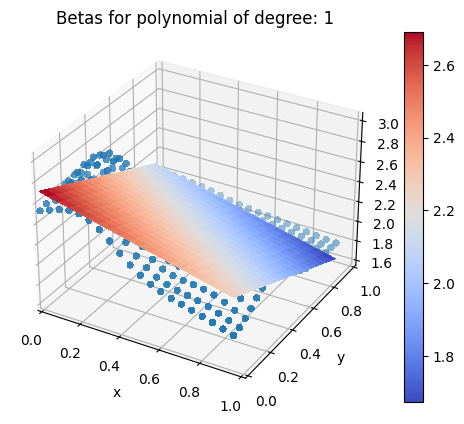

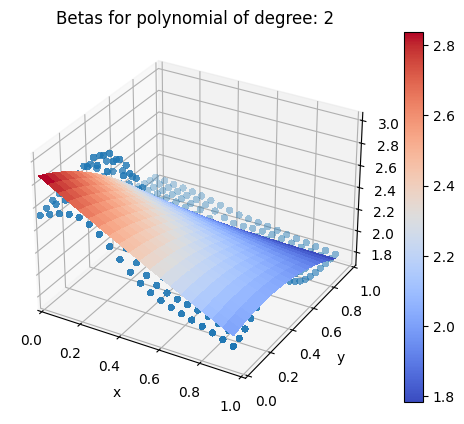

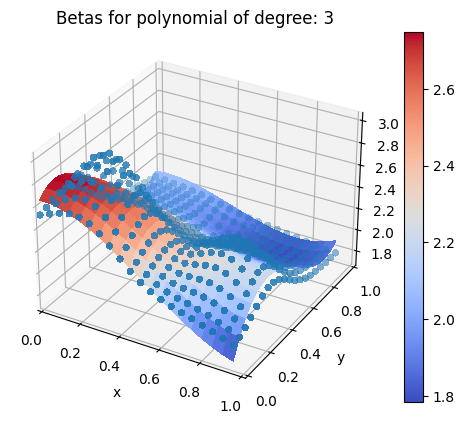

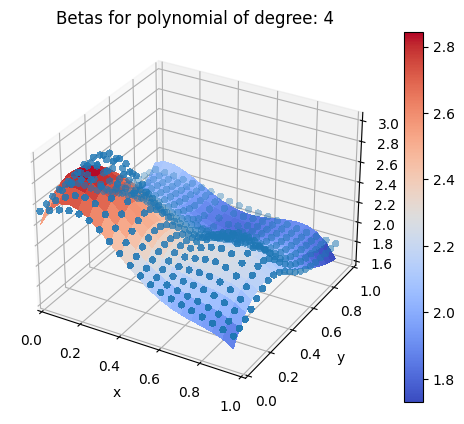

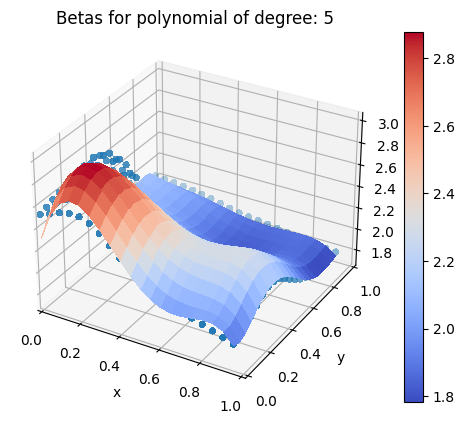

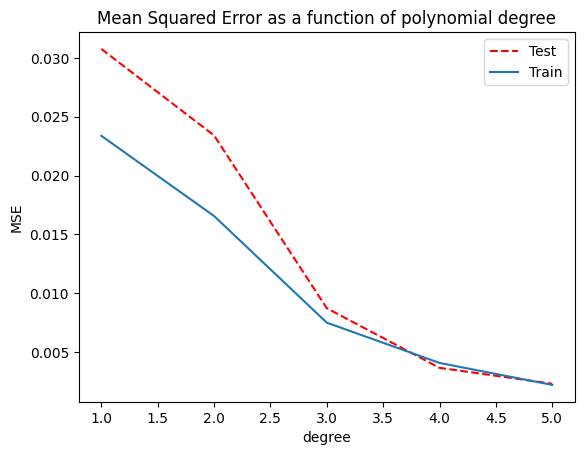

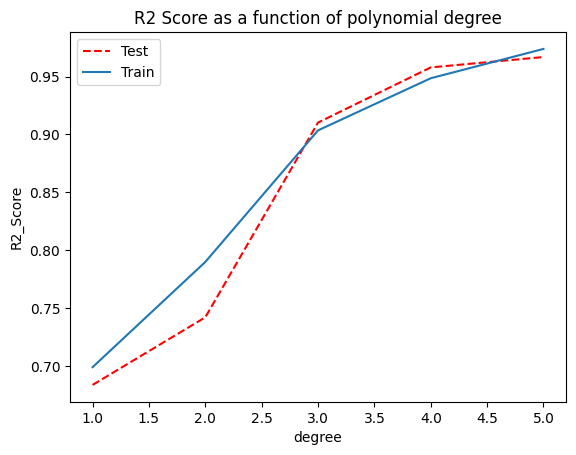

In [90]:
polydegree, TestError, TrainError, Test_R2, Train_R2 = OLS(x, y, z, 5,"Franke", True)
plot_stat(TestError, TrainError, "MSE", polydegree)
plot_stat(Test_R2, Train_R2, "R2_Score", polydegree)

Why did you scaled or not? Did not scale the data because in one sense the data is already scaled to a specific interval for both x and y.

### Part b): Adding Ridge regression for  the Franke function

Write your own code for the Ridge method, either using matrix
inversion or the singular value decomposition as done in the previous
exercise. The lecture notes from week 35 and 36 contain more information. Furthermore, the numerical exercise from week 36 is something you can reuse here.

Perform the same analysis as you did in the previous exercise but now for different values of $\lambda$. Compare and
analyze your results with those obtained in part a) with the ordinary least squares method. Study the
dependence on $\lambda$.

In [15]:
def RidgeOrLasso(x, y, z, degree, type):
    nlambdas = 100
    lambdas = np.logspace(-4, 4, nlambdas)
    MSEPredict = np.zeros(nlambdas)
    MSETrain = np.zeros(nlambdas)
    R2Predict = np.zeros(nlambdas)
    R2Train = np.zeros(nlambdas)
    betas = []

    X = designMatrix(x, y, degree)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    for i in range(nlambdas):
        lmb = lambdas[i]
        if type == "Ridge":
            I = np.identity(np.size(X_train, 1))
            beta = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
            # make the prediction
            z_tilde = X_train @ beta
            z_predict = X_test @ beta
        if type == "Lasso":
            RegLasso = linear_model.Lasso(lmb, fit_intercept = False)
            RegLasso.fit(X_train, z_train)
            z_tilde = RegLasso.predict(X_train)
            z_predict= RegLasso.predict(X_test)
            beta = RegLasso.coef_
            
        MSEPredict[i] = MSE(z_test, z_predict)
        MSETrain[i] = MSE(z_train, z_tilde)
        R2Predict[i] = R2(z_test, z_predict)
        R2Train[i] = R2(z_train, z_tilde)
        betas.append(beta)
        

    return lambdas, MSEPredict, MSETrain, R2Predict, R2Train

Now we evaluate the Ridge regression with the OLS

MSE Train for OLS with polynomial fit of degree 1: 0.023811122884163094
MSE Test for OLS with polynomial fit of degree 1: 0.028656761821872566


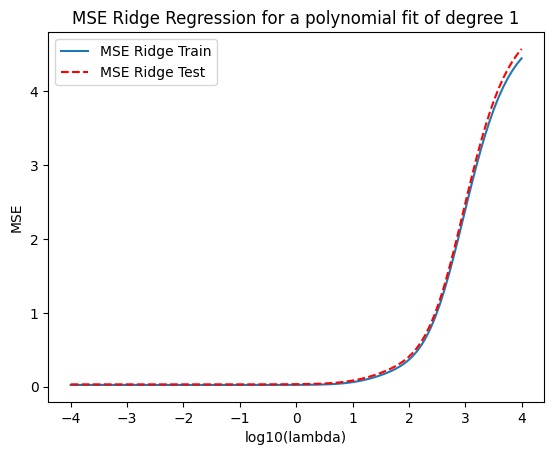

R2 Score Train for OLS with polynomial fit of degree 1: 0.7016180768479996
R2 Score Test for OLS with polynomial fit of degree 1: 0.675335798126055


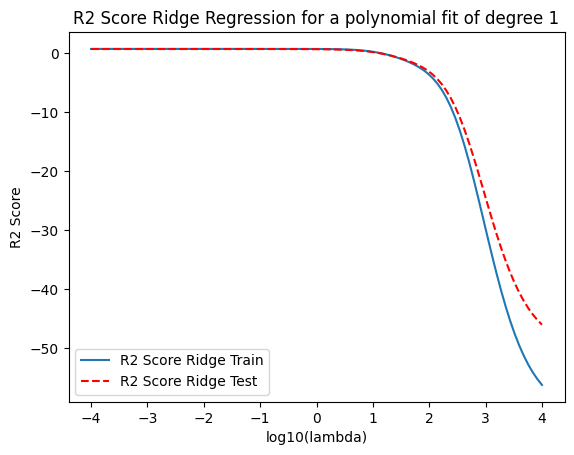

MSE Train for OLS with polynomial fit of degree 2: 0.01678287503760481
MSE Test for OLS with polynomial fit of degree 2: 0.02306446897557466


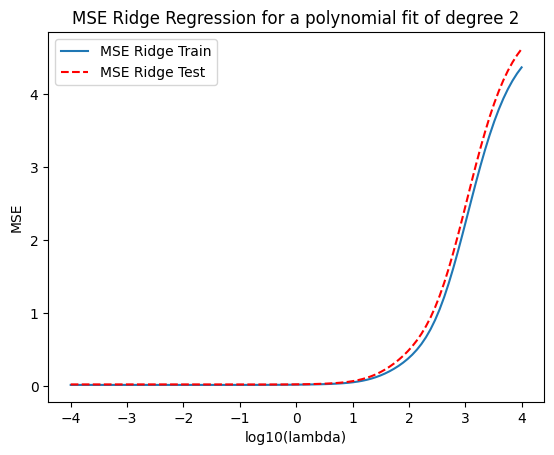

R2 Score Train for OLS with polynomial fit of degree 2: 0.7943682783678405
R2 Score Test for OLS with polynomial fit of degree 2: 0.7191542898523354


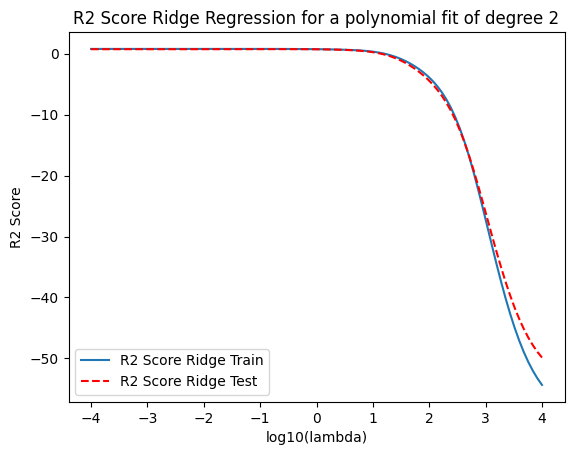

MSE Train for OLS with polynomial fit of degree 3: 0.007873026788540636
MSE Test for OLS with polynomial fit of degree 3: 0.007309431584704956


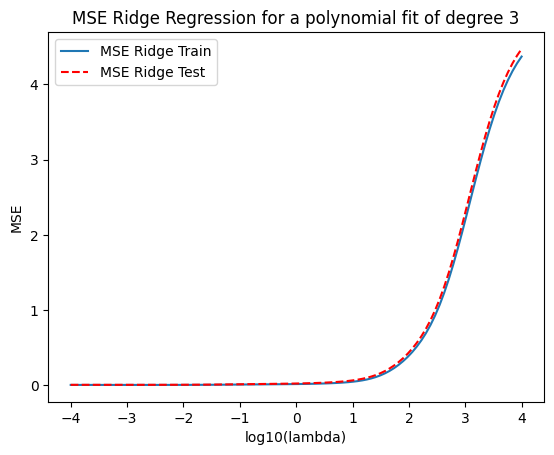

R2 Score Train for OLS with polynomial fit of degree 3: 0.9012614817267112
R2 Score Test for OLS with polynomial fit of degree 3: 0.91846439116147


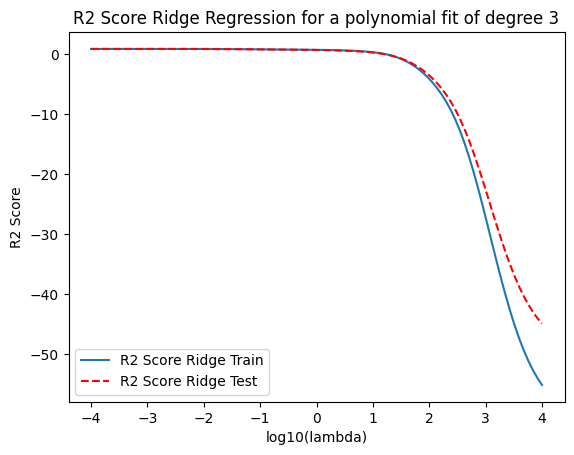

MSE Train for OLS with polynomial fit of degree 4: 0.0038192435840826064
MSE Test for OLS with polynomial fit of degree 4: 0.004685377167299515


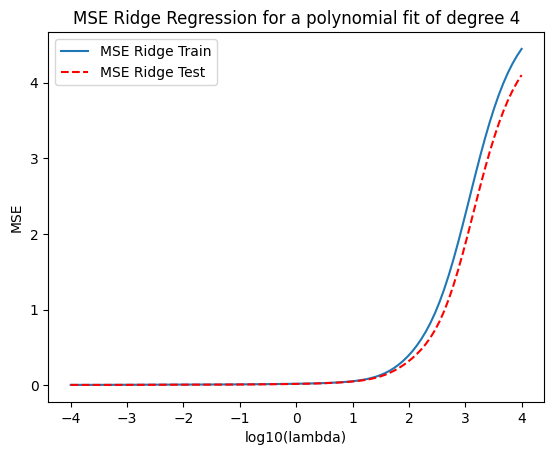

R2 Score Train for OLS with polynomial fit of degree 4: 0.9539061890147216
R2 Score Test for OLS with polynomial fit of degree 4: 0.9394595417128998


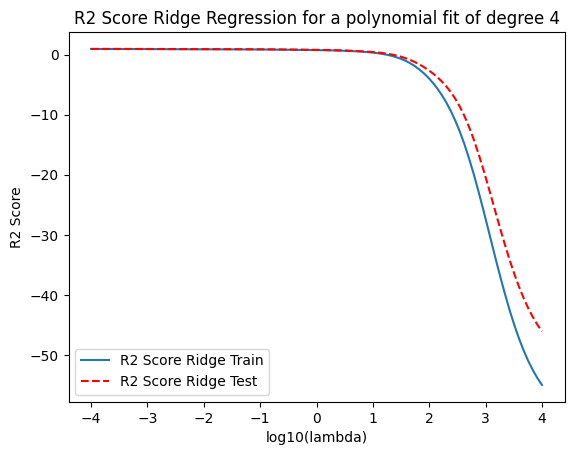

MSE Train for OLS with polynomial fit of degree 5: 0.0021854186860517425
MSE Test for OLS with polynomial fit of degree 5: 0.0024295373357225863


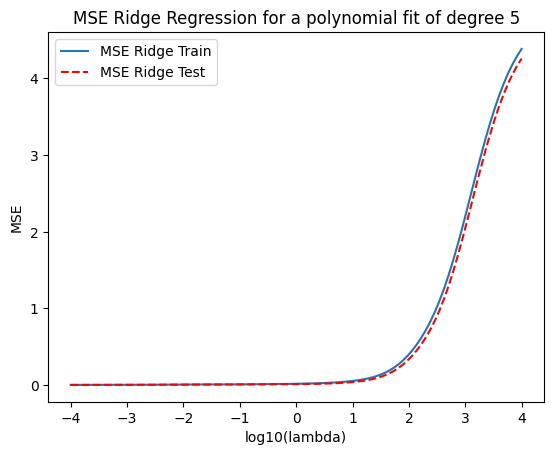

R2 Score Train for OLS with polynomial fit of degree 5: 0.973805448010516
R2 Score Test for OLS with polynomial fit of degree 5: 0.9675862056098514


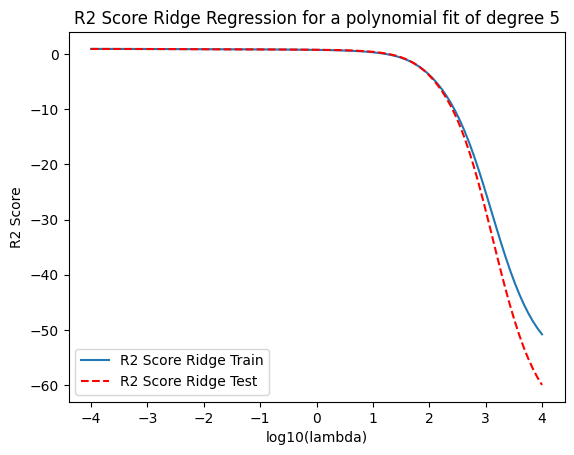

In [16]:
for degree in range(1, 6):
    lambdas, MSERidgePredict, MSERidgeTrain, R2RidgePredict, R2RidgeTrain = RidgeOrLasso(x, y, z, degree, "Ridge")
    print(f"MSE Train for OLS with polynomial fit of degree {degree}: {TrainError[degree-1]}")
    print(f"MSE Test for OLS with polynomial fit of degree {degree}: {TestError[degree-1]}")
    plt.figure()
    plt.plot(np.log10(lambdas), MSERidgeTrain, label = 'MSE Ridge Train')
    plt.plot(np.log10(lambdas), MSERidgePredict, 'r--', label = 'MSE Ridge Test')
    plt.xlabel('log10(lambda)')
    plt.ylabel('MSE')
    plt.title(f"MSE Ridge Regression for a polynomial fit of degree {degree}")
    plt.legend()
    plt.show()

    print(f"R2 Score Train for OLS with polynomial fit of degree {degree}: {Train_R2[degree-1]}")
    print(f"R2 Score Test for OLS with polynomial fit of degree {degree}: {Test_R2[degree-1]}")
    plt.figure()
    plt.plot(np.log10(lambdas), R2RidgeTrain, label = 'R2 Score Ridge Train')
    plt.plot(np.log10(lambdas), R2RidgePredict, 'r--', label = 'R2 Score Ridge Test')
    plt.xlabel('log10(lambda)')
    plt.ylabel('R2 Score')
    plt.title(f"R2 Score Ridge Regression for a polynomial fit of degree {degree}")
    plt.legend()
    plt.show()

In [17]:
def plot_stat_RvsL(degree, lambdas, statRidgeTrain, statRidgePredict, statLassoTrain, statLassoPredict, stat):
    plt.figure()
    if stat == "MSE":
        plt.plot(np.log10(lambdas), statRidgeTrain, label = 'MSE Ridge Train')
        plt.plot(np.log10(lambdas), statRidgePredict, 'r--', label = 'MSE Ridge Test')
        plt.plot(np.log10(lambdas), statLassoTrain, label = 'MSE Lasso Train')
        plt.plot(np.log10(lambdas), statLassoPredict, 'g--', label = 'MSE Lasso Test')
        plt.ylabel('MSE')
    elif stat == "R2":
        plt.plot(np.log10(lambdas), statRidgeTrain, label = 'R2 Score Ridge Train')
        plt.plot(np.log10(lambdas), statRidgePredict, 'r--', label = 'R2 Score Ridge Test')
        plt.plot(np.log10(lambdas), statLassoTrain, label = 'R2 Score Lasso Train')
        plt.plot(np.log10(lambdas), statLassoPredict, 'g--', label = 'R2 Score Lasso Test')
        plt.ylabel("R2 Score")

    plt.xlabel('log10(lambda)')
    plt.title(f"Ridge VS Lasso for a polynomial fit of degree {degree}")
    plt.legend()
    plt.show()

### Part c): Adding Lasso for the Franke function

This exercise is essentially a repeat of the previous two ones, but now
with Lasso regression. Write either your own code (difficult and optional) or, in this case,
you can also use the functionalities of **Scikit-Learn** (recommended). Keep in mind that the library **Scikit-Learn** excludes the intercept by default. 
Give a
critical discussion of the three methods and a judgement of which
model fits the data best.

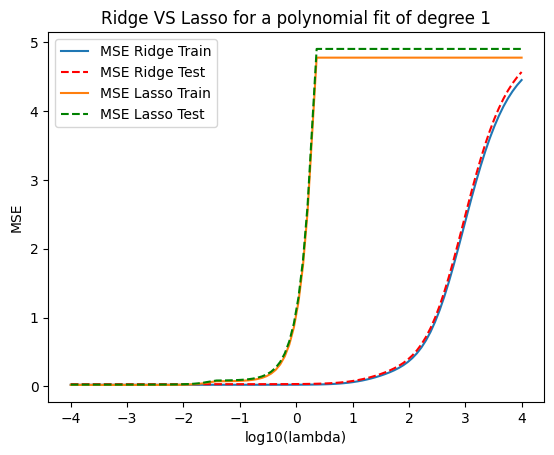

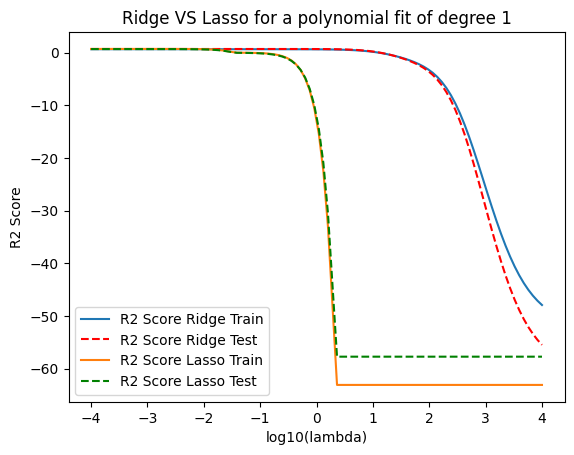

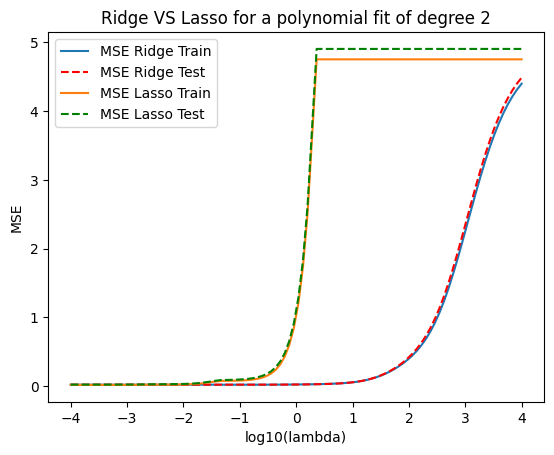

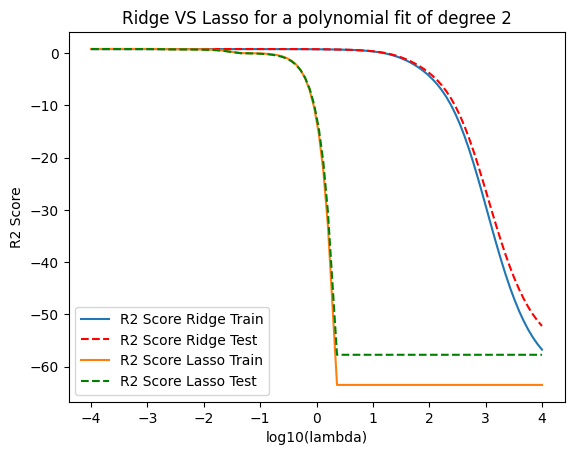

c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.083e+00, tolerance: 1.554e-01
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.016e+00, tolerance: 1.554e-01
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.328e-01, tolerance: 1.554e-01
  model = cd_fast.enet_

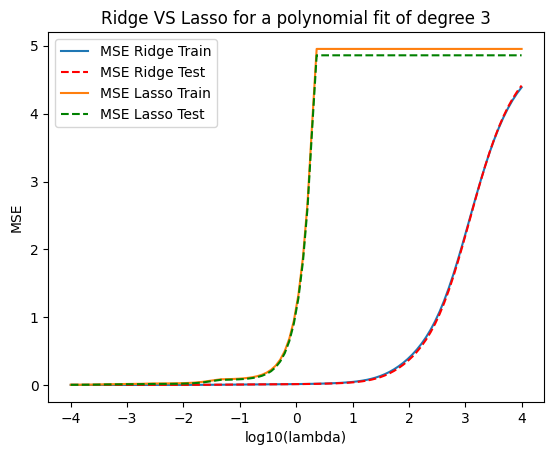

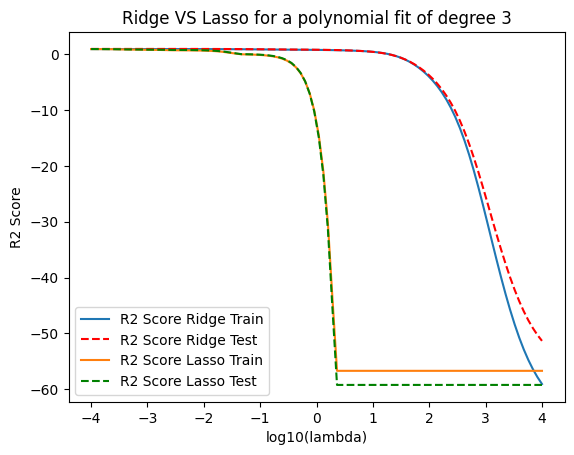

c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.850e-01, tolerance: 1.546e-01
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.408e-01, tolerance: 1.546e-01
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.975e-01, tolerance: 1.546e-01
  model = cd_fast.enet_

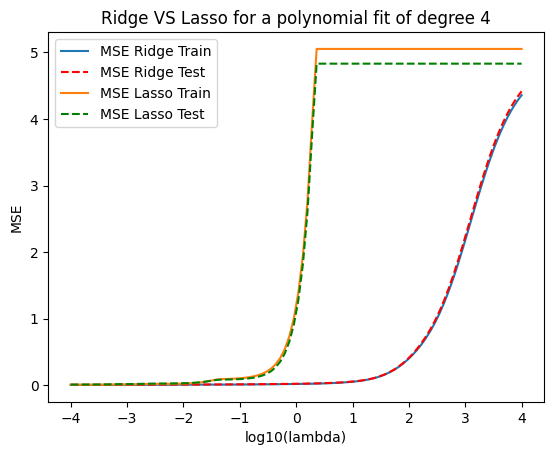

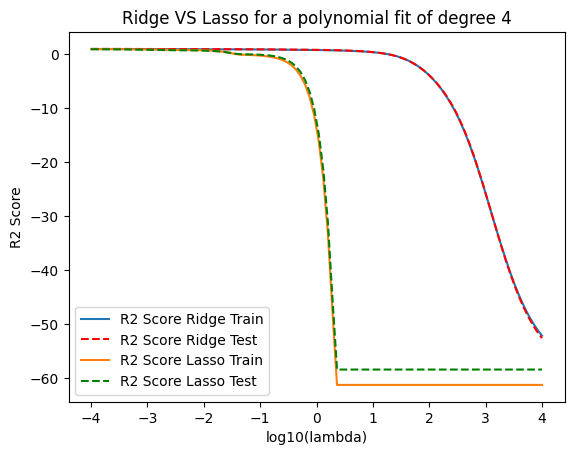

c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.549e-01, tolerance: 1.560e-01
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.922e-01, tolerance: 1.560e-01
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.784e-01, tolerance: 1.560e-01
  model = cd_fast.enet_

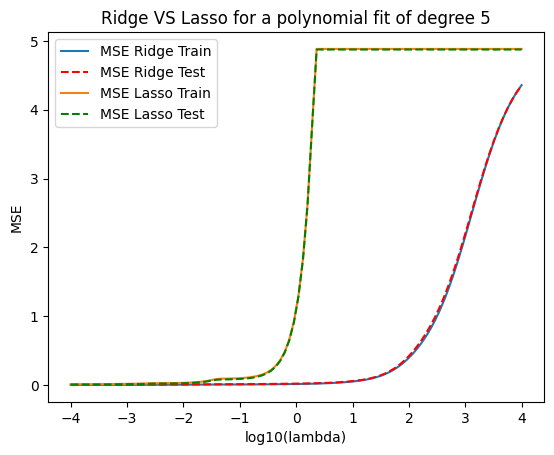

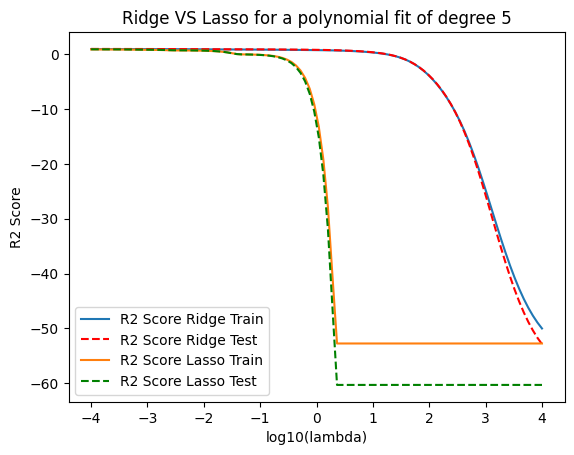

In [19]:
for degree in range(1, 6):
    lambdas, MSERidgePredict, MSERidgeTrain, R2RidgePredict, R2RidgeTrain = RidgeOrLasso(x, y, z, degree, "Ridge")
    lambdas, MSELassoPredict, MSELassoTrain, R2LassoPredict, R2LassoTrain = RidgeOrLasso(x, y, z, degree, "Lasso")
    plot_stat_RvsL(degree, lambdas, MSERidgeTrain, MSERidgePredict, MSELassoPredict, MSELassoTrain, "MSE")
    plot_stat_RvsL(degree, lambdas, R2RidgePredict, R2RidgeTrain, R2LassoPredict, R2LassoTrain, "R2")

### Part d): Paper and pencil part

This exercise deals with various mean values and variances in  linear regression method (here it may be useful to look up chapter 3, equation (3.8) of [Trevor Hastie, Robert Tibshirani, Jerome H. Friedman, The Elements of Statistical Learning, Springer](https://www.springer.com/gp/book/9780387848570)). The exercise is also part of the weekly exercises for week 37.

The assumption we have made is 
that there exists a continuous function $f(\boldsymbol{x})$ and  a normal distributed error $\boldsymbol{\varepsilon}\sim N(0, \sigma^2)$
which describes our data

$$
\boldsymbol{y} = f(\boldsymbol{x})+\boldsymbol{\varepsilon}
$$

We then approximate this function $f(\boldsymbol{x})$ with our model $\boldsymbol{\tilde{y}}$ from the solution of the linear regression equations (ordinary least squares OLS), that is our
function $f$ is approximated by $\boldsymbol{\tilde{y}}$ where we minimized  $(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2$, with

$$
\boldsymbol{\tilde{y}} = \boldsymbol{X}\boldsymbol{\beta}.
$$

The matrix $\boldsymbol{X}$ is the so-called design or feature matrix. 

Show that  the expectation value of $\boldsymbol{y}$ for a given element $i$

$$
\mathbb{E}(y_i)  =\sum_{j}x_{ij} \beta_j=\mathbf{X}_{i, \ast} \, \boldsymbol{\beta},
$$

We know that
$$y_i = f(x_i)+\epsilon_i$$

Taking the expectation of $y_i$ we get
$$\begin{align*}
\mathbb{E}(y_i) &= \mathbb{E}[f(x_i)+\epsilon_i]\\ 
&= \mathbb{E}[f(x_i)]+\mathbb{E}(\epsilon_i)
\end{align*}$$

Since we know that $\boldsymbol{\varepsilon}\sim N(0, \sigma^2)$ we know that $\mathbb{E}(\epsilon_i) = 0$, we then have
$$\mathbb{E}(y_i) = \mathbb{E}[f(x_i)]$$

Recall now that the function $f$ is approximated by $\boldsymbol{\tilde{y}}$, where
$$\boldsymbol{\tilde{y}} = \boldsymbol{X}\boldsymbol{\beta}$$

Then we can write $f(x_i)$ as 
$$\tilde{y}_i = \sum_j x_{ij}\beta_j$$

which is a continous function which depends on lineary on this unknown parameters
$\boldsymbol{\beta}^T = [\beta_0, \beta_1, \beta_2, ..., \beta_j]$

Then we have
$$\begin{align*}
\mathbb{E}[f(x_i)] = \mathbb{E}(y_i) = \tilde{y}_i
&= \sum_j x_{ij}\beta_j\\
&= x_{i,0}\beta_0+x_{i,1}\beta_1+x_{i,2}\beta_2 + ... + x_{,n-1}\beta_{n-1}\\
&= \mathbf{X}_{i, \ast} \, \boldsymbol{\beta}
\end{align*}$$ 

where $\mathbf{X}_{i, \ast}$ represents the $i$-th row of a matrix $\mathbf{X}$.

Show that
its variance is
$$
\boldsymbol{Var}(y_i)  = \sigma^2.
$$

We define the variance as
$$\begin{align*}
\boldsymbol{Var}(y_i) &= \mathbb{E}\{(y_i-\mathbb{E}(yi))^2\}\\
&=\mathbb{E}(y_i^2)-\mathbb{E(y_i)}^2
\end{align*}$$

Now using that $y_i = \mathbf{X}_{i, \ast} \, \boldsymbol{\beta} + \epsilon_i$ and $\mathbb{E}(y_i) = \mathbf{X}_{i, \ast} \, \boldsymbol{\beta}$

$$\begin{align*}
\boldsymbol{Var}(y_i) &=\mathbb{E}(y_i^2)-\mathbb{E(y_i)}^2\\
&= \mathbb{E}[(\mathbf{X}_{i, \ast} \, \boldsymbol{\beta} + \epsilon_i)^2]-(\mathbf{X}_{i, \ast} \, \boldsymbol{\beta})^2\\
\end{align*}$$

Using that
$$(\mathbf{X}_{i, \ast} \, \boldsymbol{\beta} + \epsilon_i)^2 = (\mathbf{X}_{i, \ast} \, \boldsymbol{\beta})^2 + 2\epsilon_i\mathbf{X}_{i, \ast} \, \boldsymbol{\beta} + \epsilon_i^2$$

we have
$$\mathbb{E}[(\mathbf{X}_{i, \ast} \, \boldsymbol{\beta} + \epsilon_i)^2]-(\mathbf{X}_{i, \ast} \, \boldsymbol{\beta})^2 = (\mathbf{X}_{i, \ast} \, \boldsymbol{\beta})^2 + 2\mathbb{E}(\epsilon_i)\mathbf{X}_{i, \ast}\,\boldsymbol{\beta}+\mathbb{E}(\epsilon_i^2)-(\mathbf{X}_{i, \ast}\,\boldsymbol{\beta})^2$$

Since $\boldsymbol{\varepsilon}\sim N(0, \sigma^2)$, meaning that $\mathbb{E}(\epsilon_i) = 0$, then

$$(\mathbf{X}_{i, \ast} \, \boldsymbol{\beta})^2 + 2\mathbb{E}(\epsilon_i)\mathbf{X}_{i, \ast}\,\boldsymbol{\beta}+\mathbb{E}(\epsilon_i^2)-(\mathbf{X}_{i, \ast}\,\boldsymbol{\beta})^2 = \mathbb{E}(\epsilon_i^2)$$

Still using the fact that $\mathbb{E}(\epsilon_i) = 0$, we can write 
$$\boldsymbol{Var}(\epsilon_i) = \mathbb{E}\{[\epsilon_i-\mathbb{E}(\epsilon_i)^2]\} = \mathbb{E}(\epsilon_i^2)-[\mathbb{E}(\epsilon_i)^2] = \mathbb{E}(\epsilon_i^2)$$

Hence

$$\boldsymbol{Var}(y_i) = \mathbb{E}(\epsilon_i^2) = \boldsymbol{Var}(\epsilon) = \sigma^2.$$

Hence, $y_i \sim N( \mathbf{X}_{i, \ast} \, \boldsymbol{\beta}, \sigma^2)$, that is $\boldsymbol{y}$ follows a normal distribution with 
mean value $\boldsymbol{X}\boldsymbol{\beta}$ and variance $\sigma^2$.

With the OLS expressions for the optimal parameters $\boldsymbol{\hat{\beta}}$ show that

$$
\mathbb{E}(\boldsymbol{\hat{\beta}}) = \boldsymbol{\beta}.
$$

To find the optimal parameter $\hat{\beta}$ we first need to define the cost/loss function for OLS. The cost function is a way to measure the quality of our model, we can define this function as 

$$C(\boldsymbol{\beta}) = \frac{1}{n}\{(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})^T(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})\}$$

To find $\hat{\beta}$ we need to derivative of $C(\boldsymbol{\beta})$ with respect to $\boldsymbol{\beta}^T$

$$\frac{\partial C(\boldsymbol{\beta})}{\partial\boldsymbol{\beta}^T} = 0 = \boldsymbol{X}^T(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta})$$

Solving this equation with respect to $\boldsymbol{\beta}$ we get

$$\hat{\boldsymbol{\beta}} = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{y}$$

Using this in the equation above we get

$$\mathbb{E}(\hat{\boldsymbol{\beta}}) = \mathbb{E}[(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{y}] = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\mathbb{E}(\boldsymbol{y})$$

Using that $\mathbb{E}(\boldsymbol{y}) = \boldsymbol{X}\boldsymbol{\beta}$ we get

$$(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\mathbb{E}(\boldsymbol{y}) = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{X}\boldsymbol{\beta}$$

and since is $(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{X} = \mathbb{I}$, we have that

$$\mathbb{E}(\hat{\boldsymbol{\beta}}) = \boldsymbol{\beta}$$

which is what we wanted to show.

Show finally that the variance of $\boldsymbol{\beta}$ is

$$
\boldsymbol{Var}(\boldsymbol{\hat{\beta}}) = \sigma^2 \, (\mathbf{X}^{T} \mathbf{X})^{-1}.
$$

The variance of $\boldsymbol{\hat{\beta}}$ is given by 
$$\boldsymbol{Var}(\boldsymbol{\hat{\beta}}) = \mathbb{E}\{[\boldsymbol{\hat{\beta}}-\mathbb{E}(\boldsymbol{\hat{\beta}})]^2\}$$

To ensure that $\boldsymbol{\hat{\beta}}^2$ gives an answer we multiply $\boldsymbol{\hat{\beta}}$ with its own transposed $\boldsymbol{\hat{\beta}}\boldsymbol{\hat{\beta}}^T$. Then we get an answer when $\boldsymbol{\hat{\beta}}$ is not a squared matrix. Using this in the equation above we can write 

$$\begin{align*}
\boldsymbol{Var}(\boldsymbol{\hat{\beta}}) &= \mathbb{E}\{[\boldsymbol{\hat{\beta}}-\mathbb{E}(\boldsymbol{\hat{\beta}})]^2\}\\
&=\mathbb{E}\{[\boldsymbol{\beta}-\mathbb{E}(\boldsymbol{\beta})][\boldsymbol{\beta}-\mathbb{E}(\boldsymbol{\beta})]^T\}
\end{align*}$$

Now using that $\boldsymbol{\beta} = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{y}$ and that $\mathbb{E}(\boldsymbol{\beta}) = \boldsymbol{\beta}$

$$\begin{align*}
\boldsymbol{Var}(\boldsymbol{\hat{\beta}})
&=\mathbb{E}\{[\boldsymbol{\beta}-\mathbb{E}(\boldsymbol{\beta})][\boldsymbol{\beta}-\mathbb{E}(\boldsymbol{\beta})]^T\}\\
&=\mathbb{E}\{[(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{y}-\boldsymbol{\beta}][(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{y}-\boldsymbol{\beta}]^T\}\\
&=\mathbb{E}\{(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{y}\boldsymbol{y}^T\boldsymbol{X}(\boldsymbol{X}^T\boldsymbol{X})^{-1} - \boldsymbol{\beta}\boldsymbol{\beta}^T\}\\
&=(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\mathbb{E}\{\boldsymbol{y}\boldsymbol{y}^T\}\boldsymbol{X}(\boldsymbol{X}^T\boldsymbol{X})^{-1} - \boldsymbol{\beta}\boldsymbol{\beta}^T
\end{align*}$$


Where
$$\begin{align*}
\mathbb{E}\{\boldsymbol{y}\boldsymbol{y}^T\} &= \mathbb{E}[(\boldsymbol{X}\boldsymbol{\beta}+\boldsymbol{\epsilon})(\boldsymbol{X}\boldsymbol{\beta}+\boldsymbol{\epsilon})^T]\\
&= (\boldsymbol{X}\boldsymbol{\beta}\boldsymbol{\beta}^T\boldsymbol{X}^T) + 2\boldsymbol{X}\boldsymbol{\beta}\mathbb{E}(\boldsymbol{\epsilon})+\mathbb{\boldsymbol{\epsilon}^2}\\
&= (\boldsymbol{X}\boldsymbol{\beta}\boldsymbol{\beta}^T\boldsymbol{X}^T) + \boldsymbol{Var}(\boldsymbol{\epsilon})\\
&= (\boldsymbol{X}\boldsymbol{\beta}\boldsymbol{\beta}^T\boldsymbol{X}^T) + \sigma^2
\end{align*}$$

Since $\boldsymbol{\epsilon}\sim N(0,\sigma^2)$. Then we have

$$\begin{align*}
\boldsymbol{Var}(\boldsymbol{\hat{\beta}})
&=\mathbb{E}\{[\boldsymbol{\beta}-\mathbb{E}(\boldsymbol{\beta})][\boldsymbol{\beta}-\mathbb{E}(\boldsymbol{\beta})]^T\}\\
&=(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\mathbb{E}\{\boldsymbol{y}\boldsymbol{y}^T\}\boldsymbol{X}(\boldsymbol{X}^T\boldsymbol{X})^{-1} - \boldsymbol{\beta}\boldsymbol{\beta}^T\\
&=(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\{\boldsymbol{X}\boldsymbol{\beta}\boldsymbol{\beta}^T\boldsymbol{X}^T+ \sigma^2\}\boldsymbol{X}(\boldsymbol{X}^T\boldsymbol{X})^{-1} - \boldsymbol{\beta}\boldsymbol{\beta}^T\\
&= (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{X}\boldsymbol{\beta}\boldsymbol{\beta}^T\boldsymbol{X}^T\boldsymbol{X}(\boldsymbol{X}^T\boldsymbol{X})^{-1}+ \sigma^2(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{X}(\boldsymbol{X}^T\boldsymbol{X})^{-1} - \boldsymbol{\beta}\boldsymbol{\beta}^T\\
&= \boldsymbol{\beta}\boldsymbol{\beta}^T + \sigma^2(\boldsymbol{X}^T\boldsymbol{X})^{-1}-\boldsymbol{\beta}\boldsymbol{\beta}^T\\
&= \sigma^2(\boldsymbol{X}^T\boldsymbol{X})^{-1}
\end{align*}$$

Which is what we wanted.

We can use the last expression when we define a so-called confidence interval for the parameters $\beta$. 
A given parameter $\beta_j$ is given by the diagonal matrix element of the above matrix.

### Part e): Bias-variance trade-off and resampling techniques

Our aim here is to study the bias-variance trade-off by implementing the **bootstrap** resampling technique.
**We will only use the simpler ordinary least squares here**.

With a code which does OLS and includes resampling techniques, 
we will now discuss the bias-variance trade-off in the context of
continuous predictions such as regression. However, many of the
intuitions and ideas discussed here also carry over to classification
tasks and basically all Machine Learning algorithms. 

Before you perform an analysis of the bias-variance trade-off on your test data, make
first a figure similar to Fig. 2.11 of Hastie, Tibshirani, and
Friedman. Figure 2.11 of this reference displays only the test and training MSEs. The test MSE can be used to 
indicate possible regions of low/high bias and variance. You will most likely not get an
equally smooth curve!

With this result we move on to the bias-variance trade-off analysis.

Consider a
dataset $\mathcal{L}$ consisting of the data
$\mathbf{X}_\mathcal{L}=\{(y_j, \boldsymbol{x}_j), j=0\ldots n-1\}$.

As in part d), we assume that the true data is generated from a noisy model

$$
\boldsymbol{y}=f(\boldsymbol{x}) + \boldsymbol{\epsilon}.
$$

Here $\epsilon$ is normally distributed with mean zero and standard
deviation $\sigma^2$.

In our derivation of the ordinary least squares method we defined then
an approximation to the function $f$ in terms of the parameters
$\boldsymbol{\beta}$ and the design matrix $\boldsymbol{X}$ which embody our model,
that is $\boldsymbol{\tilde{y}}=\boldsymbol{X}\boldsymbol{\beta}$.

The parameters $\boldsymbol{\beta}$ are in turn found by optimizing the mean
squared error via the so-called cost function

$$
C(\boldsymbol{X},\boldsymbol{\beta}) =\frac{1}{n}\sum_{i=0}^{n-1}(y_i-\tilde{y}_i)^2=\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right].
$$

Here the expected value $\mathbb{E}$ is the sample value. 

Show that you can rewrite  this in terms of a term which contains the variance of the model itself (the so-called variance term), a
term which measures the deviation from the true data and the mean value of the model (the bias term) and finally the variance of the noise.
That is, show that

$$
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]=(\mathrm{Bias}[\tilde{y}])^2+\mathrm{var}[\tilde{f}]+\sigma^2,
$$

Using the information we have from above, we can write.
$$
\begin{align*}
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]&= \mathbb{E}\left[((\boldsymbol{f} + \boldsymbol{\epsilon})-\boldsymbol{\tilde{y}})^2\right]\\
&= \mathbb{E}[(\boldsymbol{f} + \boldsymbol{\epsilon})^2] - \mathbb{E}[(\boldsymbol{f} + \boldsymbol{\epsilon})\boldsymbol{\tilde{y}}] + \mathbb{E}[\boldsymbol{\tilde{y}}^2]
\end{align*}$$

Solving the terms one by one, using that $\boldsymbol{\epsilon}\sim N(0,\sigma^2)$:
$$\begin{align*}
\mathbb{E}[(\boldsymbol{f} + \boldsymbol{\epsilon})^2] &= \mathbb{E}[\boldsymbol{f}^2] + 2\mathbb{E}[\boldsymbol{f}\boldsymbol{\epsilon}] + \mathbb{E}[\boldsymbol{\epsilon}^2]\\
&= \boldsymbol{f}^2 + \sigma^2
\end{align*}$$

$$
\begin{align*}
\mathbb{E}[(\boldsymbol{f} + \boldsymbol{\epsilon})\boldsymbol{\tilde{y}}] &= \mathbb{E}[\boldsymbol{f}\boldsymbol{\tilde{y}}] + \mathbb{E}[\boldsymbol{\epsilon}\boldsymbol{\tilde{y}}]\\
&= \boldsymbol{f}\mathbb{E}[\boldsymbol{\tilde{y}}]+\mathbb{E}[\boldsymbol{\tilde{y}}]\mathbb{E}[\boldsymbol{\epsilon}]\\
&= \boldsymbol{f}\mathbb{E}[\boldsymbol{\tilde{y}}]
\end{align*}$$

$$\begin{align*}
\mathbb{E}[\boldsymbol{\tilde{y}}^2] &= \boldsymbol{Var}[\boldsymbol{\tilde{y}}] + (\mathbb{E}[\boldsymbol{\tilde{y}}])^2
\end{align*}$$

Then we can rewrite the above expression
$$
\begin{align*}
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right] &= \boldsymbol{f}^2 + \sigma^2 -2\boldsymbol{f}\mathbb{E}[\boldsymbol{\tilde{y}}] + \boldsymbol{Var}[\boldsymbol{\tilde{y}}] + (\mathbb{E}[\boldsymbol{\tilde{y}}])^2\\
&= \mathbb{E}\left[(\boldsymbol{y}-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2\right]+\mathrm{Var}\left[\boldsymbol{\tilde{y}}\right]+\sigma^2\\
&=(\mathrm{Bias}[\tilde{y}])^2+\mathrm{var}[\tilde{y}]+\sigma^2
\end{align*}
$$

with

$$
(\mathrm{Bias}[\tilde{y}])^2=\left(\boldsymbol{y}-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right]\right)^2,
$$

and

$$
\mathrm{var}[\tilde{f}]=\frac{1}{n}\sum_i(\tilde{y}_i-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2.
$$

The answer to this exercise should be included in the theory part of the report.  This exercise is also part of the weekly exercises of week 37.
Explain what the terms mean and discuss their interpretations.

The three terms represent the square of the bias of the learning
method, which can be thought of as the error caused by the simplifying
assumptions built into the method. The second term represents the
variance of the chosen model and finally the last terms is variance of
the error $\boldsymbol{\epsilon}$.

I will now perform an analysis of the bias-variance trade-off on my test data, by making first a figure similar to Fig. 2.11 of Hastie, Tibshirani, and
Friedman.

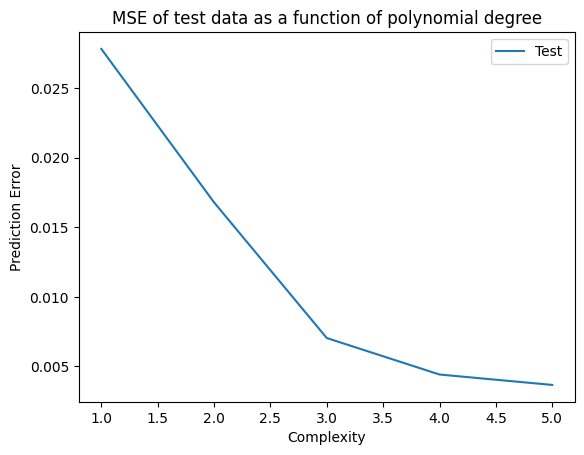

In [457]:
polydegree, TestError, TrainError, Test_R2, Train_R2 = OLS(x, y, z, 5, plot= False)
plt.plot(polydegree, TestError, label='Test')
plt.title("MSE of test data as a function of polynomial degree")
plt.xlabel("Complexity")
plt.ylabel("Prediction Error")
plt.legend()
plt.show()

Perform then a bias-variance analysis of the Franke function by
studying the MSE value as function of the complexity of your model.

Discuss the bias and variance trade-off as function
of your model complexity (the degree of the polynomial) and the number
of data points, and possibly also your training and test data using the **bootstrap** resampling method.
You can follow the code example in the jupyter-book at <https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter3.html#the-bias-variance-tradeoff>.

Polynomial degree: 1
Error: 0.03103719356361597
Bias^2: 0.030872376331344993
Var: 0.00016481723227099567
0.03103719356361597 >= 0.030872376331344993 + 0.00016481723227099567 = 0.03103719356361599
Polynomial degree: 2
Error: 0.023248978467999483
Bias^2: 0.02301669266310492
Var: 0.00023228580489457278
0.023248978467999483 >= 0.02301669266310492 + 0.00023228580489457278 = 0.023248978467999493
Polynomial degree: 3
Error: 0.009141371693261117
Bias^2: 0.008818556838067015
Var: 0.0003228148551940937
0.009141371693261117 >= 0.008818556838067015 + 0.0003228148551940937 = 0.009141371693261109
Polynomial degree: 4
Error: 0.005845223432873756
Bias^2: 0.005620254928723434
Var: 0.00022496850415032045
0.005845223432873756 >= 0.005620254928723434 + 0.00022496850415032045 = 0.005845223432873754
Polynomial degree: 5
Error: 0.002893753715498074
Bias^2: 0.002667452493669349
Var: 0.0002263012218287225
0.002893753715498074 >= 0.002667452493669349 + 0.0002263012218287225 = 0.0028937537154980716


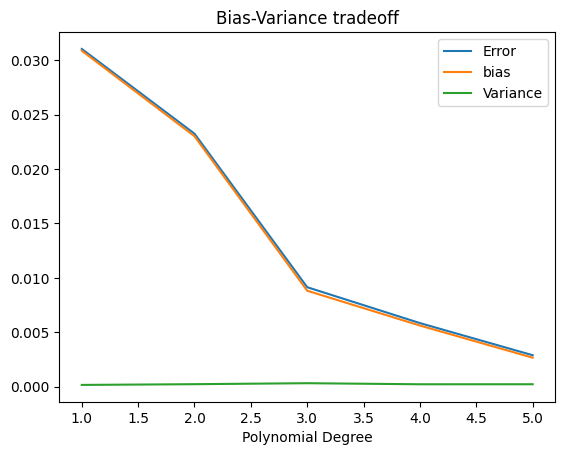

Polynomial degree: 1
Error: 0.024075394112916655
Bias^2: 0.023863481411508077
Var: 0.00021191270140858068
0.024075394112916655 >= 0.023863481411508077 + 0.00021191270140858068 = 0.02407539411291666
Polynomial degree: 2
Error: 0.017705134062560274
Bias^2: 0.017381703070299116
Var: 0.00032343099226117604
0.017705134062560274 >= 0.017381703070299116 + 0.00032343099226117604 = 0.01770513406256029
Polynomial degree: 3
Error: 0.0087435206384996
Bias^2: 0.008515523695465871
Var: 0.00022799694303371547
0.0087435206384996 >= 0.008515523695465871 + 0.00022799694303371547 = 0.008743520638499586
Polynomial degree: 4
Error: 0.004397810767569287
Bias^2: 0.004121697542161615
Var: 0.0002761132254076803
0.004397810767569287 >= 0.004121697542161615 + 0.0002761132254076803 = 0.004397810767569295
Polynomial degree: 5
Error: 0.0025993747260110688
Bias^2: 0.0020175094263575628
Var: 0.0005818652996535072
0.0025993747260110688 >= 0.0020175094263575628 + 0.0005818652996535072 = 0.00259937472601107


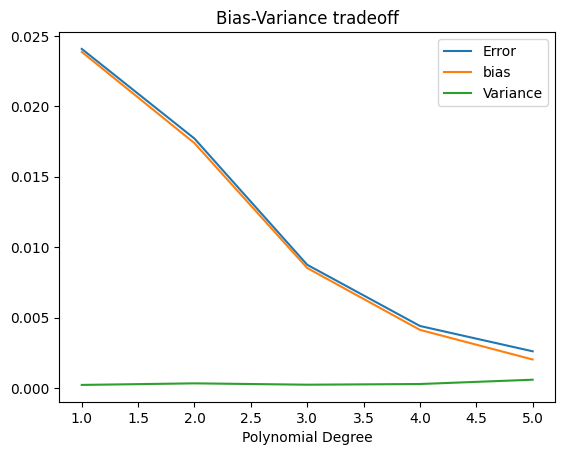

Polynomial degree: 1
Error: 0.03170207989926186
Bias^2: 0.031490917099439256
Var: 0.00021116279982260128
0.03170207989926186 >= 0.031490917099439256 + 0.00021116279982260128 = 0.031702079899261854
Polynomial degree: 2
Error: 0.015976643224040292
Bias^2: 0.015626015281495848
Var: 0.0003506279425444511
0.015976643224040292 >= 0.015626015281495848 + 0.0003506279425444511 = 0.0159766432240403
Polynomial degree: 3
Error: 0.00864374604660762
Bias^2: 0.008394510615279715
Var: 0.00024923543132791554
0.00864374604660762 >= 0.008394510615279715 + 0.00024923543132791554 = 0.00864374604660763
Polynomial degree: 4
Error: 0.006022089115041301
Bias^2: 0.005736027106582593
Var: 0.0002860620084587125
0.006022089115041301 >= 0.005736027106582593 + 0.0002860620084587125 = 0.006022089115041305
Polynomial degree: 5
Error: 0.0020162166049307677
Bias^2: 0.0017425516559268453
Var: 0.00027366494900391984
0.0020162166049307677 >= 0.0017425516559268453 + 0.00027366494900391984 = 0.002016216604930765


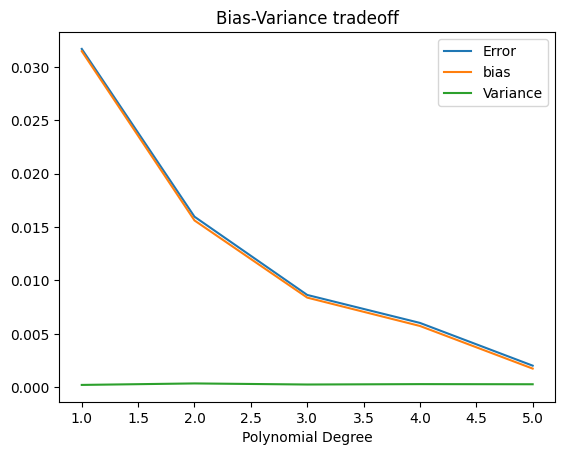

In [60]:
def bias_variance_tradeoff(x, y, z, maxdegree, n_boostraps):
    error = np.zeros(maxdegree)
    bias = np.zeros(maxdegree)
    variance = np.zeros(maxdegree)
    polydegree = np.zeros(maxdegree)

    for degree in range(1, maxdegree+1):
        X = designMatrix(x,y, degree)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        z_pred = np.empty((z_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
            x_, z_ = resample(X_train, z_train)
            beta = (SVDinv(x_.T@x_)@x_.T)@z_
            z_pred[:, i] = X_test@beta

        index = degree-1
        polydegree[index] = degree
        # Calculate error, bias, and variance
        error[index] = np.mean(np.mean((z_test[:, np.newaxis] - z_pred) ** 2, axis=1))
        bias[index] = np.mean((z_test - np.mean(z_pred, axis=1)) ** 2)
        variance[index] = np.mean(np.var(z_pred, axis=1))
        print('Polynomial degree:', degree)
        print('Error:', error[index])
        print('Bias^2:', bias[index])
        print('Var:', variance[index])
        print('{} >= {} + {} = {}'.format(error[index], bias[index], variance[index], bias[index]+variance[index]))

    plt.plot(polydegree, error, label='Error')
    plt.plot(polydegree, bias, label='bias')
    plt.plot(polydegree, variance, label='Variance')
    plt.xlabel('Polynomial Degree')
    plt.title("Bias-Variance tradeoff")
    plt.legend()
    plt.show()


maxdegree = 5

bias_variance_tradeoff(x, y, z, maxdegree, 10)
bias_variance_tradeoff(x, y, z, maxdegree, 50)
bias_variance_tradeoff(x ,y, z, maxdegree, 100)

### Part f):  Cross-validation as resampling techniques, adding more complexity

The aim here is to write your own code for another widely popular
resampling technique, the so-called cross-validation method.  

Implement the $k$-fold cross-validation algorithm (write your own
code) and evaluate again the MSE function resulting
from the test folds. You can compare your own code with that from
**Scikit-Learn** if needed. 

Compare the MSE you get from your cross-validation code with the one
you got from your **bootstrap** code. Comment your results. Try $5-10$
folds.  You can also compare your own cross-validation code with the
one provided by **Scikit-Learn**.

In addition to using the ordinary least squares method, you should include both Ridge and Lasso regression.

In [108]:
def k_fold_cross_validation(x, y, z, degree, type, k=5, lmb=1):
    X = designMatrix(x, y, degree)
    n = len(X)
    fold_size = n // k
    scores_KFold = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size

        X_test = X[start:end]
        z_test = z[start:end]

        X_train = np.concatenate((X[:start], X[end:]), axis=0)
        z_train = np.concatenate((z[:start], z[end:]), axis=0)

        if type == "OLS":
            beta = (SVDinv(X_train.T@X_train)@X_train.T)@z_train
            z_tilde = X_train@beta
            z_pred = X_test@beta
        elif type == "Ridge":
            I = np.identity(np.size(X_train, 1))
            beta = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
            z_tilde = X_train@beta
            z_pred = X_test@beta
        elif type == "Lasso":
            RegLasso = linear_model.Lasso(lmb, fit_intercept = False)
            RegLasso.fit(X_train, z_train)
            z_tilde = RegLasso.predict(X_train)
            z_pred= RegLasso.predict(X_test)
            beta = RegLasso.coef_


        scores_KFold.append(np.sum((z_pred - z_test[:, np.newaxis])**2)/np.size(z_pred))
    
    estimated_mse_KFold = np.mean(scores_KFold)
    return estimated_mse_KFold

In [120]:
def Cross_Validation_plot(x,y, z):
    degrees = []
    scores = []
    print("Results for OLS")
    for i in range(1, 6):
        degrees.append(i)
        test_scores = k_fold_cross_validation(x, y, z, i, "OLS", k=5, lmb=1)
        scores.append(test_scores)
        # print(f"Polynomial degree {i}, test score: {test_scores}")
    plt.plot(degrees, scores)
    plt.ylabel("mse")
    plt.xlabel("polynomial degree")
    plt.title("K-fold Cross validation OLS")
    plt.show()

    color = ['r--', 'g--', 'b--', 'y--', 'p--']
    print("Results for Ridge")
    for i in range(1, 6):
        scores = []
        for j in lambdas:
            test_scores = k_fold_cross_validation(x, y, z, i, "Ridge", k=5, lmb=1)
            scores.append(test_scores)
            #print(f"Polynomial degree {i}, lambda = {j},  test score: {test_scores}")
        plt.plot(np.log10(lambdas), scores, color[i-1], label = f"Degree {i}")
    plt.ylabel("mse")
    plt.xlabel("log10(lambda)")
    plt.title("K-fold Cross validation Ridge")
    plt.legend()
    plt.show()

    print("Results for Lasso")
    for i in range(1, 6):
        scores = []
        for j in lambdas:
            test_scores = k_fold_cross_validation(x, y, z, i, "Lasso", k=5, lmb=j)
            scores.append(test_scores)
            #print(f"Polynomial degree {i}, lambda = {j},  test score: {test_scores}")
        
        plt.plot(np.log10(lambdas), scores, color[i-1], label = f"Degree {i}")
    plt.ylabel("mse")
    plt.xlabel("log10(lambda)")
    plt.title("K-fold Cross validation Lasso")
    plt.legend()
    plt.show()

Results for OLS


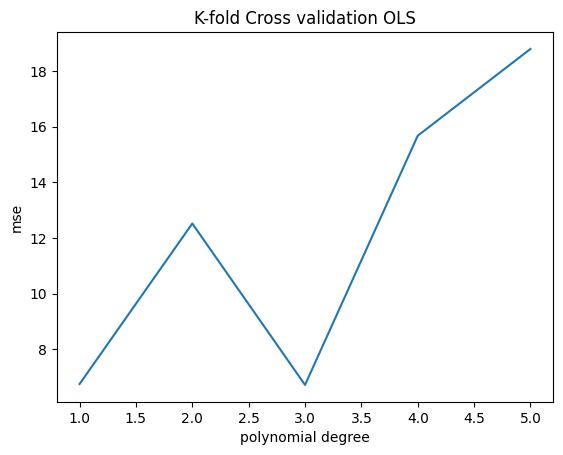

Results for Ridge


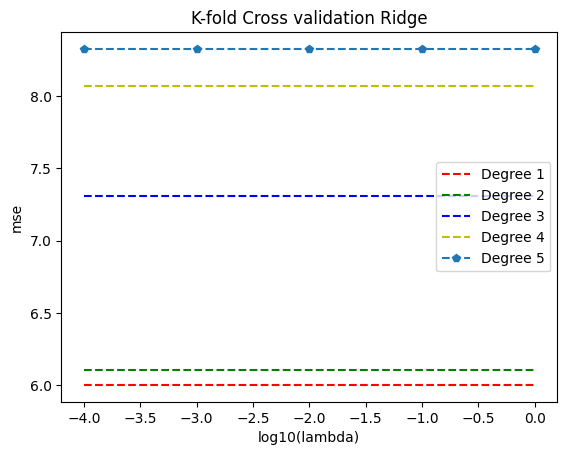

Results for Lasso


c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e-01, tolerance: 1.500e-01
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.555e-01, tolerance: 1.457e-01
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.258e+00, tolerance: 1.556e-01
  model = cd_fast.enet_

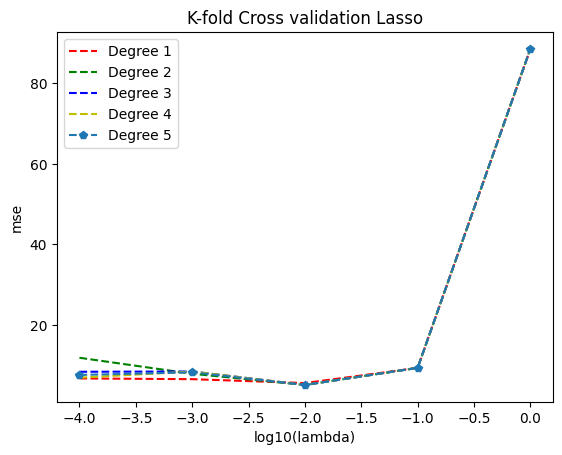

In [121]:
Cross_Validation_plot(x, y, z)

### Part g): Analysis of real data

With our codes functioning and having been tested properly on a
simpler function we are now ready to look at real data. We will
essentially repeat in this exercise what was done in exercises a-f. However, we
need first to download the data and prepare properly the inputs to our
codes.  We are going to download digital terrain data from the website
<https://earthexplorer.usgs.gov/>,

Or, if you prefer, we have placed selected datafiles at <https://github.com/CompPhysics/MachineLearning/tree/master/doc/Projects/2023/Project1/DataFiles>

In order to obtain data for a specific region, you need to register as
a user (free) at this website and then decide upon which area you want
to fetch the digital terrain data from.  In order to be able to read
the data properly, you need to specify that the format should be **SRTM
Arc-Second Global** and download the data as a **GeoTIF** file.  The
files are then stored in *tif* format which can be imported into a
Python program using

In [284]:
#scipy.misc.imread

Here is a simple part of a Python code which reads and plots the data
from such files

C:\Users\camil\AppData\Local\Temp\ipykernel_17044\2846780947.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain = imread('SRTM_data_Norway_1.tif')


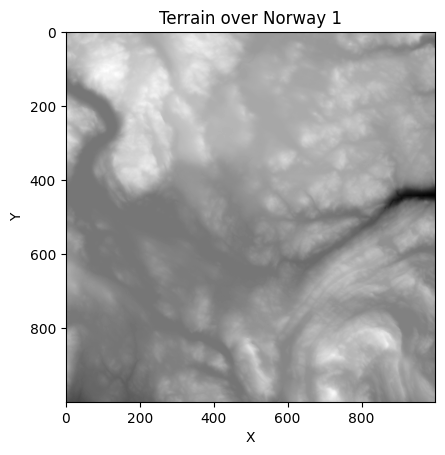

In [25]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from numpy.random import normal, uniform

# Load the terrain
terrain = imread('SRTM_data_Norway_1.tif')

#Since the shape of the original array is (3601, 1801) we will just look at a part of the terrain data, say  with shape (1000, 1000)
N = 1000
m = 5 # polynomial order
terrain = terrain[:N,:N]
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x_mesh, y_mesh = np.meshgrid(x,y)

z_terrain = terrain

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

If you should have problems in downloading the digital terrain data,
we provide two examples under the data folder of project 1. One is
from a region close to Stavanger in Norway and the other Møsvatn
Austfjell, again in Norway.
Feel free to produce your own terrain data.

Alternatively, if you would like to use another data set, feel free to do so. This could be data close to your reseach area or simply a data set you found interesting. See for example [kaggle.com](https://www.kaggle.com/datasets) for examples.

Our final part deals with the parameterization of your digital terrain
data (or your own data).  We will apply all three methods for linear regression, the same type (or higher order) of polynomial
approximation and cross-validation as resampling technique to evaluate which
model fits the data best.

At the end, you should present a critical evaluation of your results
and discuss the applicability of these regression methods to the type
of data presented here (either the terrain data we propose or other data sets).

# Ordinary Least Squares 
Plotting the estimated betas againt the real data, plus plotting the MSE and Train Error for polynomial degree one up to fifth order.

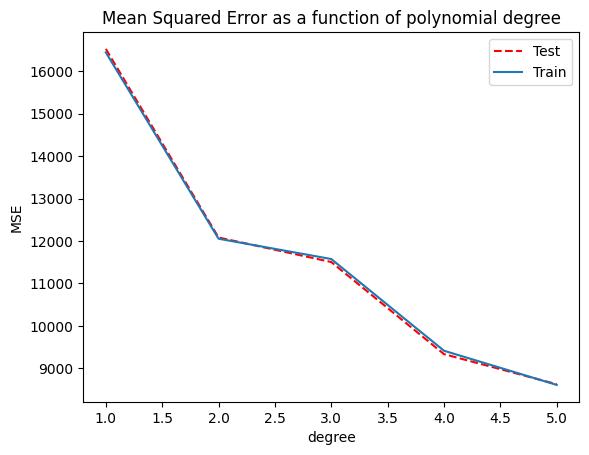

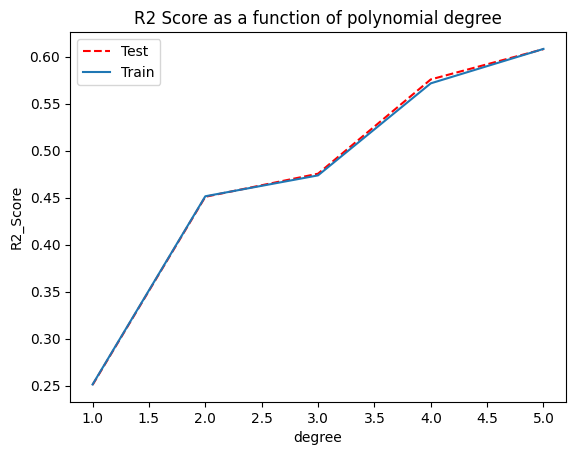

In [26]:
z_terrain = z_terrain.ravel()
polydegree, TestError, TrainError, Test_R2, Train_R2 = OLS(x_mesh, y_mesh, z_terrain, m, "Terrain", False)
plot_stat(TestError, TrainError, "MSE", polydegree)
plot_stat(Test_R2, Train_R2, "R2_Score", polydegree)

# Ridge Regression

MSE Train for OLS with polynomial fit of degree 1: 16442.91053985438
MSE Test for OLS with polynomial fit of degree 1: 16524.104713745834


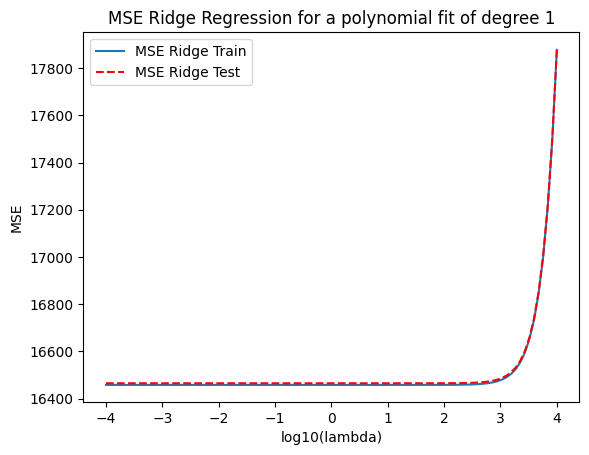

R2 Score Train for OLS with polynomial fit of degree 1: 0.251335735854637
R2 Score Test for OLS with polynomial fit of degree 1: 0.25084322238341317


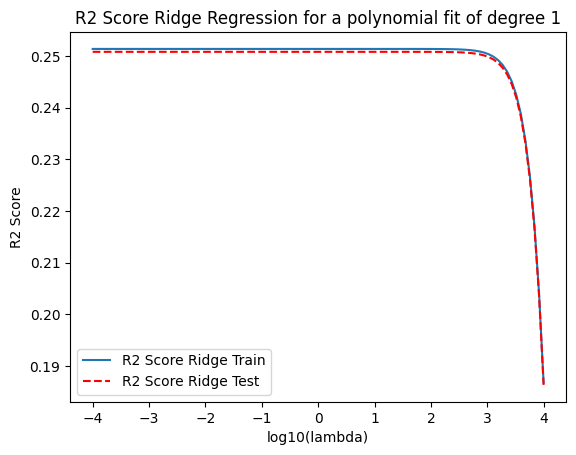

MSE Train for OLS with polynomial fit of degree 2: 12053.565188053384
MSE Test for OLS with polynomial fit of degree 2: 12082.29799965567


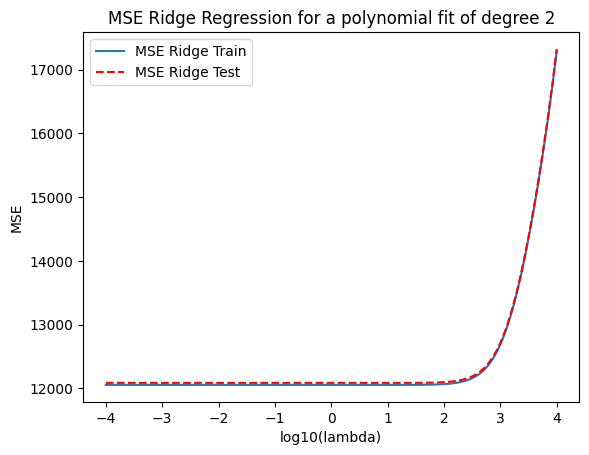

R2 Score Train for OLS with polynomial fit of degree 2: 0.45150960757720404
R2 Score Test for OLS with polynomial fit of degree 2: 0.450932773491465


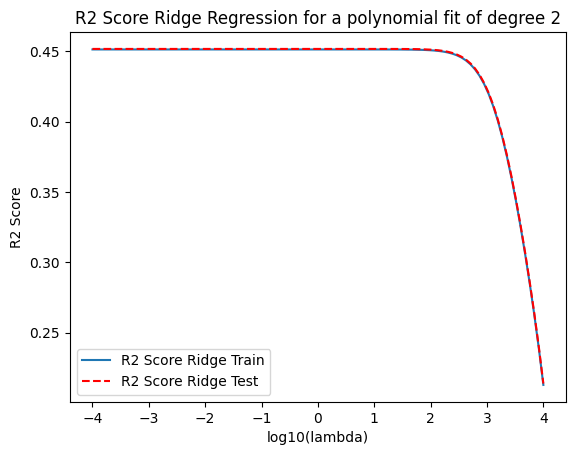

MSE Train for OLS with polynomial fit of degree 3: 11574.89678741209
MSE Test for OLS with polynomial fit of degree 3: 11504.167668935414


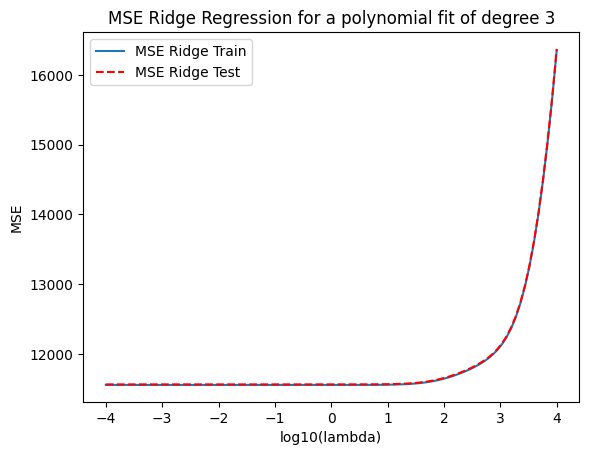

R2 Score Train for OLS with polynomial fit of degree 3: 0.47371671898671497
R2 Score Test for OLS with polynomial fit of degree 3: 0.4755142996900761


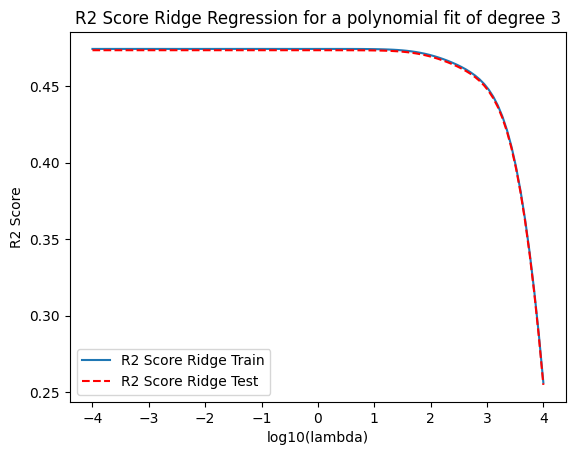

MSE Train for OLS with polynomial fit of degree 4: 9414.447285377479
MSE Test for OLS with polynomial fit of degree 4: 9334.547349845761


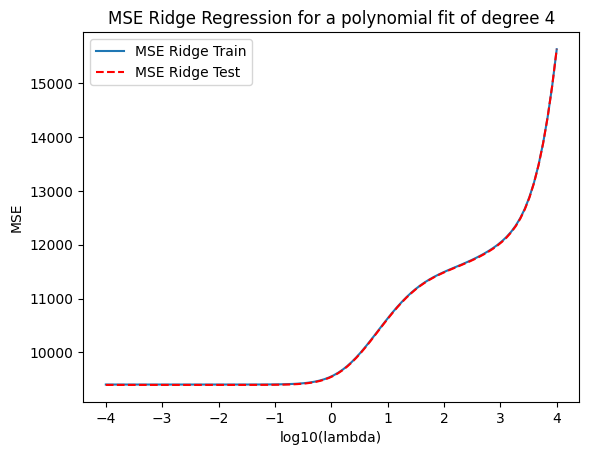

R2 Score Train for OLS with polynomial fit of degree 4: 0.5716091851500815
R2 Score Test for OLS with polynomial fit of degree 4: 0.5757729783623826


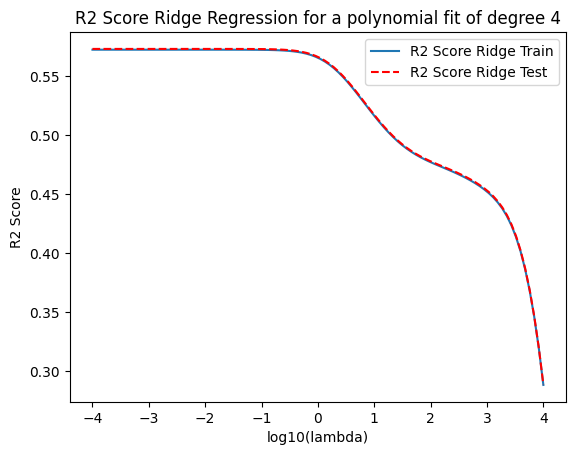

MSE Train for OLS with polynomial fit of degree 5: 8609.522204052455
MSE Test for OLS with polynomial fit of degree 5: 8625.922706571106


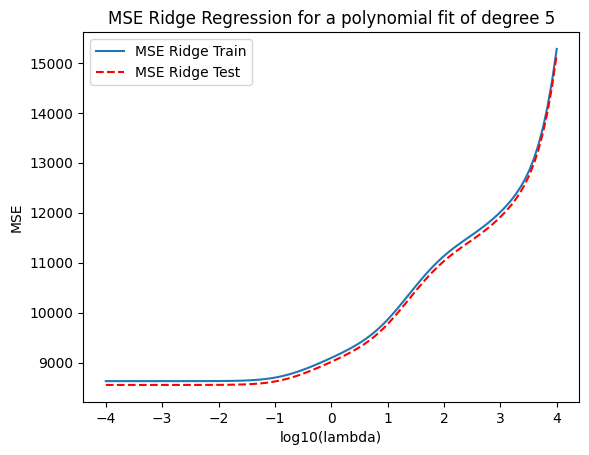

R2 Score Train for OLS with polynomial fit of degree 5: 0.608228788605961
R2 Score Test for OLS with polynomial fit of degree 5: 0.6080085808521352


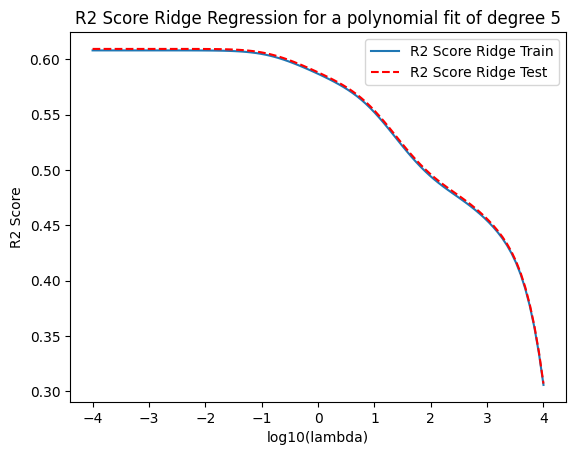

In [27]:
for degree in range(1, 6):
    lambdas, MSERidgePredict, MSERidgeTrain, R2RidgePredict, R2RidgeTrain = RidgeOrLasso(x_mesh, y_mesh, z_terrain, degree, "Ridge")
    print(f"MSE Train for OLS with polynomial fit of degree {degree}: {TrainError[degree-1]}")
    print(f"MSE Test for OLS with polynomial fit of degree {degree}: {TestError[degree-1]}")
    plt.figure()
    plt.plot(np.log10(lambdas), MSERidgeTrain, label = 'MSE Ridge Train')
    plt.plot(np.log10(lambdas), MSERidgePredict, 'r--', label = 'MSE Ridge Test')
    plt.xlabel('log10(lambda)')
    plt.ylabel('MSE')
    plt.title(f"MSE Ridge Regression for a polynomial fit of degree {degree}")
    plt.legend()
    plt.show()

    print(f"R2 Score Train for OLS with polynomial fit of degree {degree}: {Train_R2[degree-1]}")
    print(f"R2 Score Test for OLS with polynomial fit of degree {degree}: {Test_R2[degree-1]}")
    plt.figure()
    plt.plot(np.log10(lambdas), R2RidgeTrain, label = 'R2 Score Ridge Train')
    plt.plot(np.log10(lambdas), R2RidgePredict, 'r--', label = 'R2 Score Ridge Test')
    plt.xlabel('log10(lambda)')
    plt.ylabel('R2 Score')
    plt.title(f"R2 Score Ridge Regression for a polynomial fit of degree {degree}")
    plt.legend()
    plt.show()

# Lasso Regression

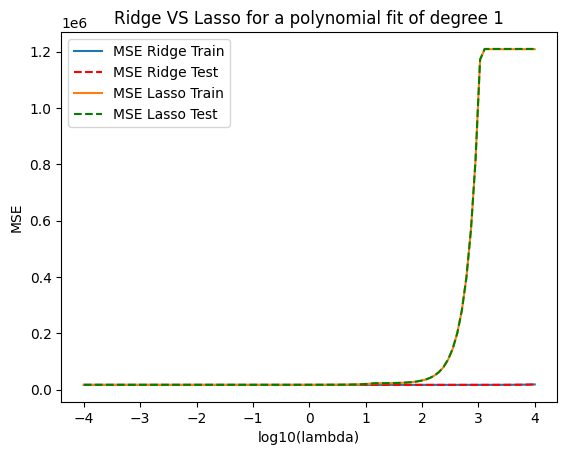

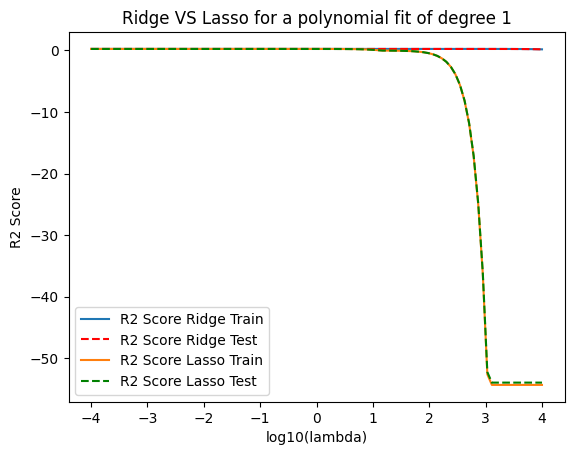

c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.601e+08, tolerance: 9.674e+07
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.729e+08, tolerance: 9.674e+07
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e+08, tolerance: 9.674e+07
  model = cd_fast.enet_

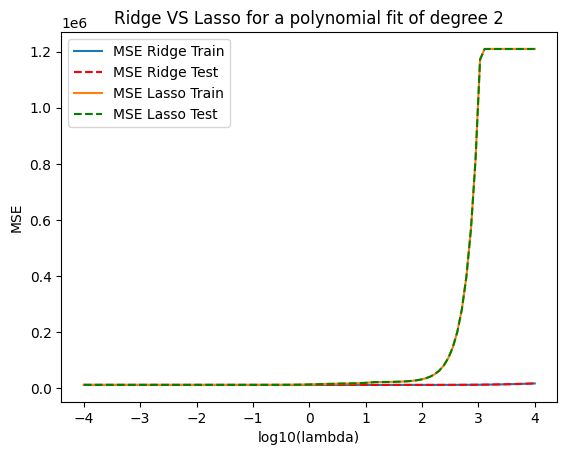

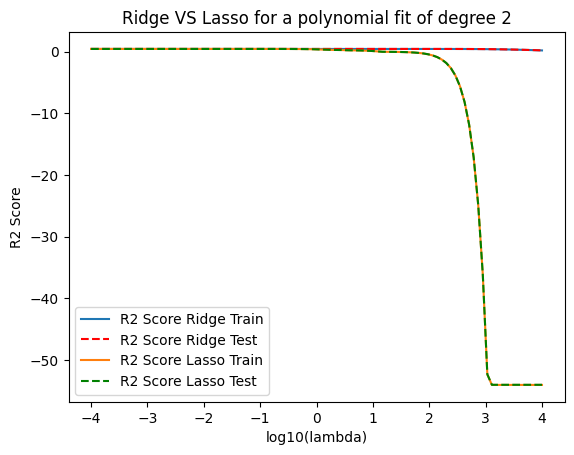

c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.607e+09, tolerance: 9.675e+07
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.602e+09, tolerance: 9.675e+07
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.596e+09, tolerance: 9.675e+07
  model = cd_fast.enet_

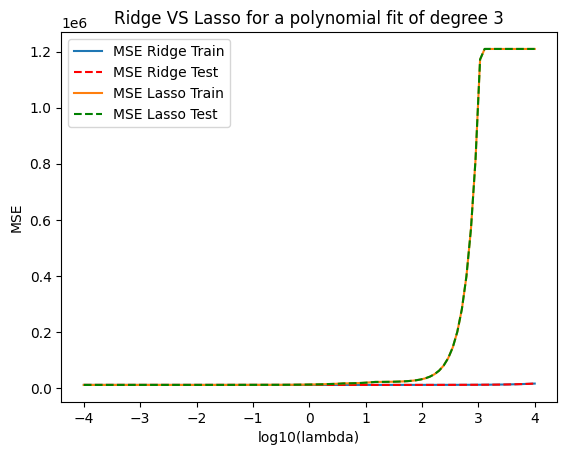

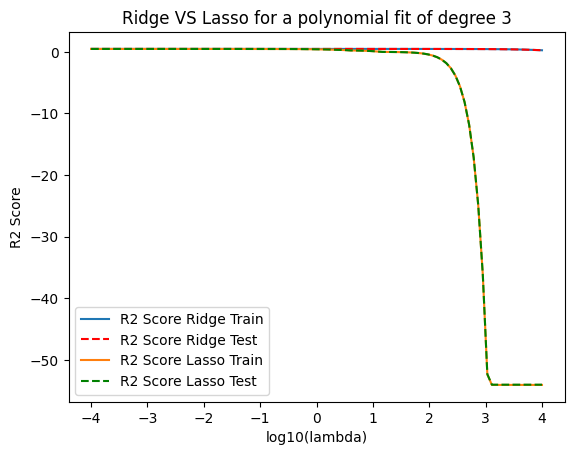

c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.515e+09, tolerance: 9.674e+07
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.513e+09, tolerance: 9.674e+07
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.510e+09, tolerance: 9.674e+07
  model = cd_fast.enet_

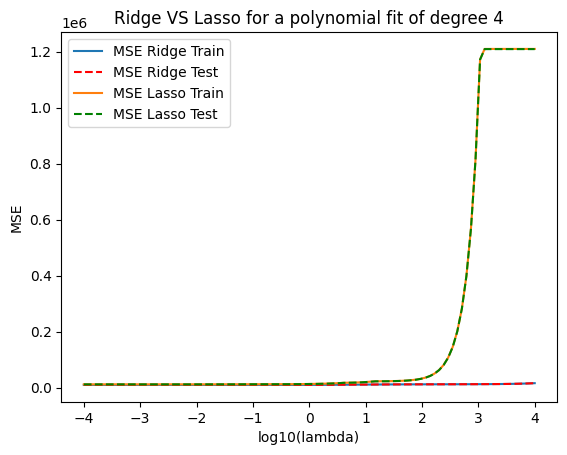

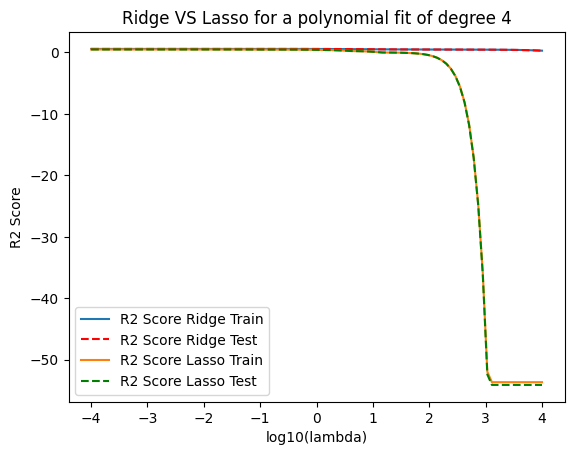

c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.361e+09, tolerance: 9.674e+07
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.360e+09, tolerance: 9.674e+07
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.358e+09, tolerance: 9.674e+07
  model = cd_fast.enet_

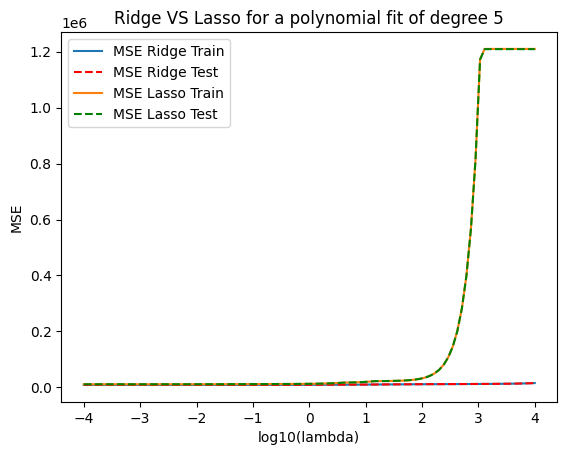

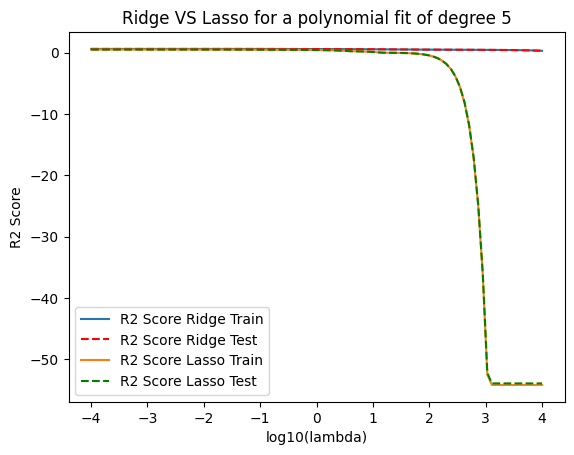

In [28]:
for degree in range(1, 6):
    lambdas, MSERidgePredict, MSERidgeTrain, R2RidgePredict, R2RidgeTrain = RidgeOrLasso(x_mesh, y_mesh, z_terrain, degree, "Ridge")
    lambdas, MSELassoPredict, MSELassoTrain, R2LassoPredict, R2LassoTrain = RidgeOrLasso(x_mesh, y_mesh, z_terrain, degree, "Lasso")
    plot_stat_RvsL(degree, lambdas, MSERidgeTrain, MSERidgePredict, MSELassoPredict, MSELassoTrain, "MSE")
    plot_stat_RvsL(degree, lambdas, R2RidgePredict, R2RidgeTrain, R2LassoPredict, R2LassoTrain, "R2")

# Bias-variance tradeoff

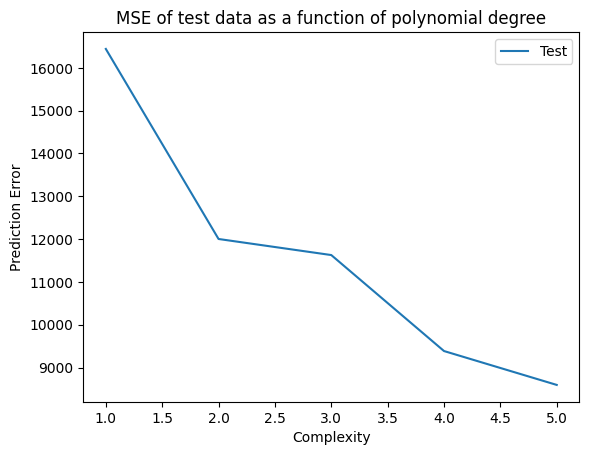

In [30]:
polydegree, TestError, TrainError, Test_R2, Train_R2 = OLS(x_mesh, y_mesh, z_terrain, 5, plot= False)
plt.plot(polydegree, TestError, label='Test')
plt.title("MSE of test data as a function of polynomial degree")
plt.xlabel("Complexity")
plt.ylabel("Prediction Error")
plt.legend()
plt.show()

Polynomial degree: 1
Error: 16441.12737541593
Bias^2: 16441.08489410745
Var: 0.04248130848102482
16441.12737541593 >= 16441.08489410745 + 0.04248130848102482 = 16441.127375415934
Polynomial degree: 2
Error: 12103.126217085612
Bias^2: 12103.037210461078
Var: 0.08900662453145265
12103.126217085612 >= 12103.037210461078 + 0.08900662453145265 = 12103.12621708561
Polynomial degree: 3
Error: 11547.207077672616
Bias^2: 11547.030292897698
Var: 0.176784774914827
11547.207077672616 >= 11547.030292897698 + 0.176784774914827 = 11547.207077672612
Polynomial degree: 4
Error: 9438.144438218043
Bias^2: 9437.956571164626
Var: 0.18786705341871418
9438.144438218043 >= 9437.956571164626 + 0.18786705341871418 = 9438.144438218045
Polynomial degree: 5
Error: 8623.451501512785
Bias^2: 8623.207375751572
Var: 0.2441257612133188
8623.451501512785 >= 8623.207375751572 + 0.2441257612133188 = 8623.451501512785


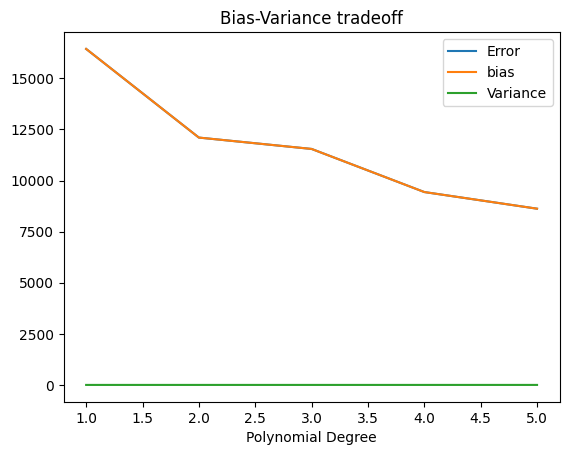

Polynomial degree: 1
Error: 16546.17010268105
Bias^2: 16546.104810679768
Var: 0.0652920012842552
16546.17010268105 >= 16546.104810679768 + 0.0652920012842552 = 16546.17010268105
Polynomial degree: 2
Error: 12096.479891838157
Bias^2: 12096.392673769122
Var: 0.08721806903310922
12096.479891838157 >= 12096.392673769122 + 0.08721806903310922 = 12096.479891838155
Polynomial degree: 3
Error: 11512.315230111688
Bias^2: 11512.154908245207
Var: 0.16032186647877822
11512.315230111688 >= 11512.154908245207 + 0.16032186647877822 = 11512.315230111686
Polynomial degree: 4
Error: 9364.657238016913
Bias^2: 9364.456691552516
Var: 0.2005464643986881
9364.657238016913 >= 9364.456691552516 + 0.2005464643986881 = 9364.657238016915
Polynomial degree: 5
Error: 8611.564356171306
Bias^2: 8611.32132813775
Var: 0.24302803355565702
8611.564356171306 >= 8611.32132813775 + 0.24302803355565702 = 8611.564356171306


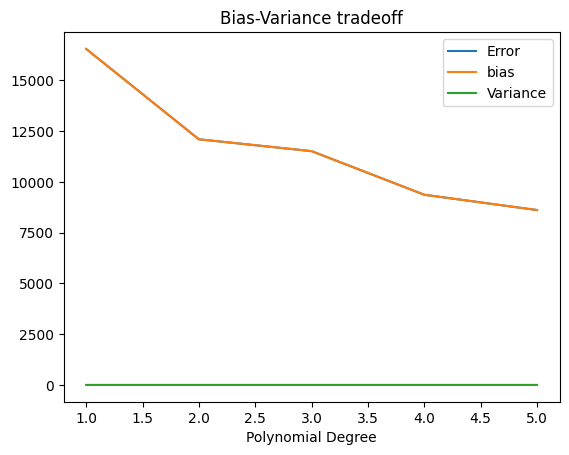

Polynomial degree: 1
Error: 16464.76463556957
Bias^2: 16464.7009829871
Var: 0.06365258247219974
16464.76463556957 >= 16464.7009829871 + 0.06365258247219974 = 16464.764635569572
Polynomial degree: 2
Error: 12088.564306827078
Bias^2: 12088.46479150292
Var: 0.09951532415507883
12088.564306827078 >= 12088.46479150292 + 0.09951532415507883 = 12088.564306827075
Polynomial degree: 3
Error: 11514.777869786903
Bias^2: 11514.622359090867
Var: 0.15551069603774473
11514.777869786903 >= 11514.622359090867 + 0.15551069603774473 = 11514.777869786905
Polynomial degree: 4
Error: 9386.249889941057
Bias^2: 9386.052809945475
Var: 0.19707999558187309
9386.249889941057 >= 9386.052809945475 + 0.19707999558187309 = 9386.249889941057
Polynomial degree: 5
Error: 8611.036093588284
Bias^2: 8610.774355129466
Var: 0.2617384588182113
8611.036093588284 >= 8610.774355129466 + 0.2617384588182113 = 8611.036093588284


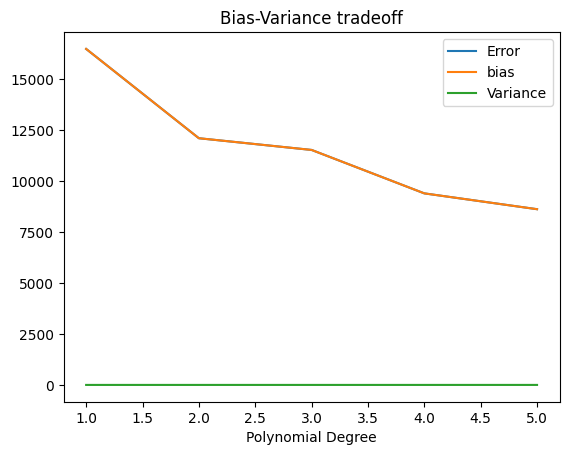

In [61]:
bias_variance_tradeoff(x_mesh, y_mesh, z_terrain, m, 10)
bias_variance_tradeoff(x_mesh, y_mesh, z_terrain, m, 50)
bias_variance_tradeoff(x_mesh ,y_mesh, z_terrain, m, 100)

# K-fold Cross-Validation

Results for OLS


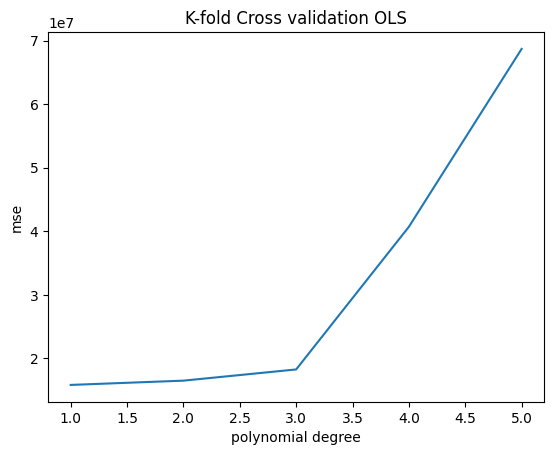

Results for Ridge


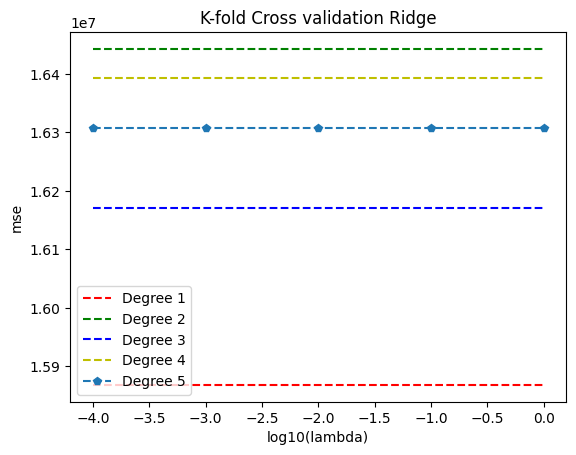

Results for Lasso


c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.137e+06, tolerance: 1.355e+06
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+06, tolerance: 1.355e+06
  model = cd_fast.enet_coordinate_descent(
c:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.532e+06, tolerance: 1.355e+06
  model = cd_fast.enet_

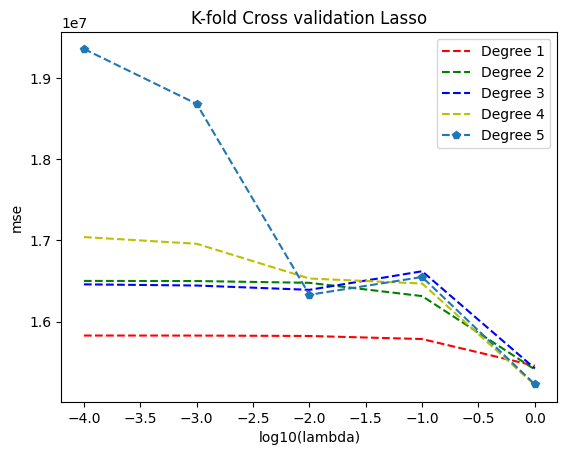

In [122]:
#Since the shape of the original array is (3601, 1801) we will just look at a part of the terrain data, say  with shape (1000, 1000)
N = 100
terrain = terrain[:N,:N]
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x_mesh, y_mesh = np.meshgrid(x,y)

z_terrain = terrain
z_terrain = z_terrain.ravel()

Cross_Validation_plot(x_mesh, y_mesh, z_terrain)

## Background literature

1. For a discussion and derivation of the variances and mean squared errors using linear regression, see the [Lecture notes on ridge regression by Wessel N. van Wieringen](https://arxiv.org/abs/1509.09169)

2. The textbook of [Trevor Hastie, Robert Tibshirani, Jerome H. Friedman, The Elements of Statistical Learning, Springer](https://www.springer.com/gp/book/9780387848570), chapters 3 and 7 are the most relevant ones for the analysis here.

## Introduction to numerical projects

Here follows a brief recipe and recommendation on how to answer the various questions when preparing your answers. 

  * Give a short description of the nature of the problem and the eventual  numerical methods you have used.

  * Describe the algorithm you have used and/or developed. Here you may find it convenient to use pseudocoding. In many cases you can describe the algorithm in the program itself.

  * Include the source code of your program. Comment your program properly. You should have the code at your GitHub/GitLab link. You can also place the code in an appendix of your report.

  * If possible, try to find analytic solutions, or known limits in order to test your program when developing the code.

  * Include your results either in figure form or in a table. Remember to        label your results. All tables and figures should have relevant captions        and labels on the axes.

  * Try to evaluate the reliabilty and numerical stability/precision of your results. If possible, include a qualitative and/or quantitative discussion of the numerical stability, eventual loss of precision etc.

  * Try to give an interpretation of you results in your answers to  the problems.

  * Critique: if possible include your comments and reflections about the  exercise, whether you felt you learnt something, ideas for improvements and  other thoughts you've made when solving the exercise. We wish to keep this course at the interactive level and your comments can help us improve it.

  * Try to establish a practice where you log your work at the  computerlab. You may find such a logbook very handy at later stages in your work, especially when you don't properly remember  what a previous test version  of your program did. Here you could also record  the time spent on solving the exercise, various algorithms you may have tested or other topics which you feel worthy of mentioning.

## Format for electronic delivery of report and programs

The preferred format for the report is a PDF file. You can also use DOC or postscript formats or as an ipython notebook file.  As programming language we prefer that you choose between C/C++, Fortran2008, Julia or Python. The following prescription should be followed when preparing the report:

  * Use Canvas to hand in your projects, log in  at  <https://www.uio.no/english/services/it/education/canvas/> with your normal UiO username and password.

  * Upload **only** the report file or the link to your GitHub/GitLab or similar typo of  repos!  For the source code file(s) you have developed please provide us with your link to your GitHub/GitLab or similar  domain.  The report file should include all of your discussions and a list of the codes you have developed.  Do not include library files which are available at the course homepage, unless you have made specific changes to them.

  * In your GitHub/GitLab or similar repository, please include a folder which contains selected results. These can be in the form of output from your code for a selected set of runs and input parameters.

Finally, 
we encourage you to collaborate. Optimal working groups consist of 
2-3 students. You can then hand in a common report.

## Software and needed installations

If you have Python installed (we recommend Python3) and you feel pretty familiar with installing different packages, 
we recommend that you install the following Python packages via **pip** as
1. pip install numpy scipy matplotlib ipython scikit-learn tensorflow sympy pandas pillow

For Python3, replace **pip** with **pip3**.

See below for a discussion of **tensorflow** and **scikit-learn**. 

For OSX users we recommend also, after having installed Xcode, to install **brew**. Brew allows 
for a seamless installation of additional software via for example
1. brew install python3

For Linux users, with its variety of distributions like for example the widely popular Ubuntu distribution
you can use **pip** as well and simply install Python as 
1. sudo apt-get install python3  (or python for python2.7)

etc etc. 

If you don't want to install various Python packages with their dependencies separately, we recommend two widely used distrubutions which set up  all relevant dependencies for Python, namely
1. [Anaconda](https://docs.anaconda.com/) Anaconda is an open source distribution of the Python and R programming languages for large-scale data processing, predictive analytics, and scientific computing, that aims to simplify package management and deployment. Package versions are managed by the package management system **conda**

2. [Enthought canopy](https://www.enthought.com/product/canopy/)  is a Python distribution for scientific and analytic computing distribution and analysis environment, available for free and under a commercial license.

Popular software packages written in Python for ML are

* [Scikit-learn](http://scikit-learn.org/stable/), 

* [Tensorflow](https://www.tensorflow.org/),

* [PyTorch](http://pytorch.org/) and 

* [Keras](https://keras.io/).

These are all freely available at their respective GitHub sites. They 
encompass communities of developers in the thousands or more. And the number
of code developers and contributors keeps increasing.